In [48]:
%matplotlib notebook
import pandas as pd
import numpy as np
import math
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
from mlxtend.plotting import plot_confusion_matrix
import warnings
from scipy.signal import savgol_filter, find_peaks, correlate
from sklearn.decomposition import PCA
import scipy.fftpack as FFT
from sklearn.utils import shuffle
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [12,5]

# Firebase

In [49]:
#connection with firestore
cred = credentials.Certificate("./healthrecommendersystems-firebase-adminsdk-psl7m-6f276b3d23.json")
app = firebase_admin.initialize_app(cred)

store = firestore.client()

users_ref = store.collection(u'users')
docs = users_ref.stream()

#dict with dataframes for al the users
users = {}

NameError: name 'credentials' is not defined

## help functions

In [ ]:
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def convert_to_datetime(x):
    dt = datetime.fromtimestamp(x // 1000000000)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    s += '.' + str(int(x % 1000000000)).zfill(9)
    return s

def heatmap(cm, labels):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

    plt.show()
    
def preprocess(data, activity, drop_interval_begin = 3, drop_interval_end = 3):
    #convert nanoseconds to date 
    data['time'] = data['time'].apply(convert_to_datetime) 
    data['time'] = pd.to_datetime(data['time'])

#convert to same data type
    for i in range(1, 4): 
        data[column_names_org[i]] = data[column_names_org[i]].apply(convert_to_float)
    
#drop rows with NaN values 
    data.dropna(axis=0, how='any', inplace=True) #TODO: invullen met mean, mod of median / interpolatie

#drop duplicates 
    data.drop_duplicates(subset=None, keep='first', inplace = True)
    
    #drop first and last 3 sec
    indexFirst = data[ (data['time'].iloc[0]+ pd.to_timedelta(drop_interval_begin, unit='s')) > data['time'] ].index
    data.drop(indexFirst , inplace=True)
    indexLast = data[ (data['time'].iloc[-1]- pd.to_timedelta(drop_interval_end, unit='s')) < data['time'] ].index
    data.drop(indexLast , inplace=True)
    
    #add activity label
    data['activity'] = activity
    
    return data

#feature extraction
def get_mean_window(df):
    return df.mean()

def get_min_window(df):
    return df.min()

def get_max_window(df):
    return df.max()

def get_std_window(df):
    return df.std()

def get_med_window(df):
    return df.median()

#TODO: scipy integrate
#TODO: voor elke as apart??
#measure of activity level (m/s²)
def get_signal_magnitude_area(df):
        sum = 0
        for i in range(0, len(df)):
            sum += (abs(df['x'].iloc[i]) + abs(df['y'].iloc[i]) + abs(df['z'].iloc[i]))
        return sum /len(df)
    #result = integrate.quad(lambda t: df['x'].apply(lambda n : abs(n)) + df['y'].apply(lambda n : abs(n)) + df['z'].apply(lambda n : abs(n)), 0, len(df))

#TODO: voor elke as apart??
#degree of movement intensity (m/s²)
def get_signal_magnitude_vector(df):
    sum = 0
    for i in range(0, len(df)):
        sum += math.sqrt(df['x'].iloc[i] * df['x'].iloc[i] + df['y'].iloc[i] * df['y'].iloc[i] + df['z'].iloc[i] * df['z'].iloc[i])
    return sum

#average angle (radian) between accelerometer vector and x as (parallel with arm)
def get_tilt_angle(df):
    df_cos = pd.DataFrame(columns=["tilt_ang"])
    df_dot = df['x']
    for i in range(0, len(df)):
        s = pd.Series({"tilt_ang" : (df_dot.iloc[i])/(math.sqrt(df['x'].iloc[i]*df['x'].iloc[i] + df['y'].iloc[i]*df['y'].iloc[i] + df['z'].iloc[i]*df['z'].iloc[i]))})
        df_cos=df_cos.append(s, ignore_index=True)
    df_angle = np.arccos(df_cos)
    return df_angle.mean()['tilt_ang']

def get_power_spectral_density(df):
    df_psd = np.abs(df)**2
    return df_psd.sum()

#TODO: datatype is object en niet compex nr
def get_entropy(df):
    entropy = []
    pdf = df / df.sum()
    for i in range (1, len(pdf.columns)):
        entropy.append(np.complex(-np.nansum(pdf.iloc[:,i] * np.log2(pdf.iloc[:,i]))))
    return entropy

#generate windows with 50% overlap
def windows(df, time, overlap):
    start = df.iloc[0]
    while  (start + pd.to_timedelta(time, unit='s')) < df.iloc[-1]:
        yield start, (start + pd.to_timedelta(time, unit='s'))
        if overlap:
            start += pd.to_timedelta(time/2, unit='s')
        else:
            start += pd.to_timedelta(time, unit='s')
        
def feature_extraction_segmentation(data, window, overlap):
    column_names = ["x_mean", "y_mean", "z_mean", "x_min", "y_min", "z_min", "x_max", "y_max", "z_max",
                "x_std", "y_std", "z_std", "x_med", "y_med", "z_med", "activity"]
    df = pd.DataFrame(columns = column_names)

    for (start, end) in windows(data['time'], window, overlap):
        vw1 = data['time'] >= start
        vw2 = data['time'] < end
        mean = get_mean_window(data[vw1 & vw2])
        min = get_min_window(data[vw1 & vw2])
        max = get_max_window(data[vw1 & vw2])
        std = get_std_window(data[vw1 & vw2])
        med = get_med_window(data[vw1 & vw2])
        sma = get_signal_magnitude_area(data[vw1 & vw2])
        smv = get_signal_magnitude_vector(data[vw1 & vw2])
        tilt = get_tilt_angle(data[vw1 & vw2])
        #fourrier transform
        t_x = data[vw1 & vw2][['time','x']].set_index('time')
        t_y = data[vw1 & vw2][['time','y']].set_index('time')
        t_z = data[vw1 & vw2][['time', 'z']].set_index('time')

        df_f = pd.DataFrame(columns=['f', 'x_f', 'y_f', 'z_f'])

    #TODO: determine sampling rate (datapoints per second)
        sampling_rate = 18

        df_f['x_f'] = FFT.fft(t_x).ravel()
        df_f['y_f'] = FFT.fft(t_y).ravel()
        df_f['z_f'] = FFT.fft(t_z).ravel()
        df_f['f'] = FFT.fftfreq(len(df_f['x_f'])) * sampling_rate

        psd = get_power_spectral_density(df_f)
        #entropy = get_entropy(df_f)

        df = df.append(pd.Series({'x_mean': mean['x'], 'y_mean': mean['y'], 'z_mean': mean['z'], "x_min" : min['x'],
                              "y_min" : min['y'], "z_min" : min['z'], "x_max" : max['x'], "y_max" : max['y'], "z_max" : max['z'],
                              "x_std" : std['x'], "y_std" : std['y'], "z_std" : std['z'], "x_med" : med['x'], "y_med" : med['y'], "z_med" : med['z'],
                              "sma" : sma, "smv" : smv, "tilt" : tilt, "x_psd" : psd['x_f'], "y_psd" : psd['y_f'], "z_psd" : psd['z_f']
                              , "activity" : data['activity'].iloc[0]}), ignore_index=True) # "x_entropy" : entropy[0], "y_entropy" : entropy[1], "z_entropy" : entropy[2],
    return df


# preprocessing

## jump_mixed: slow and fast jumping

In [ ]:
column_names_org = ['time', 'x', 'y', 'z']

jump_mixed = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\normal2.csv", sep=';', header=0, skipinitialspace=True)

jump_mixed.shape

In [ ]:
jump_mixed = preprocess(jump_mixed, "normal")

jump_mixed.tail()

In [ ]:
jump_mixed.plot(x='time', subplots=True)

#### number of turns

In [ ]:
#smoothing signal (eig niet nodig)
period = pd.DataFrame(jump_mixed)
period['x'] = savgol_filter(period[ 'x'].to_numpy(), 31, 3)
period['y'] = savgol_filter(period[ 'y'].to_numpy(), 31, 3)
period['z'] = savgol_filter(period[ 'z'].to_numpy(), 31, 3)
period.plot(x='time', subplots=True)

In [ ]:
'''
def get_number_of_turns(df, col):
    duration = df['time'].iloc[-1] - df['time'].iloc[0] 
    local_min = pd.DataFrame()
    local_min = df[(df[col].shift(1) > df[col]) & (df[col].shift(-1) > df[col])][['time', col]].reset_index()
    local_min['deltaT'] = local_min.time - local_min.time.shift(1)
    return duration/(local_min['deltaT'].mean())'''

def get_number_of_turns_threshold(df, col, percentage):
    duration = df['time'].iloc[-1] - df['time'].iloc[0] 
    local_min = pd.DataFrame()
    local_min = df[(df[col].shift(1) > df[col]) & (df[col].shift(-1) > df[col])][['time', col]].reset_index()
    
    min_local_min = local_min[col].min()
    max_local_min = local_min[col].max()
    delta_local_min = max_local_min - min_local_min
    threshold_up =  min_local_min + (percentage * delta_local_min)
    local_min = local_min[(local_min[col] < threshold_up) & (local_min[col] > min_local_min)]
    
    local_min['deltaT'] = local_min.time - local_min.time.shift(1)
    return duration/(local_min['deltaT'].mean())

def get_number_of_turns_fft(df, col):
    w = np.fft.fft(df[col])
    print (np.absolute(w))
    
def get_number_of_turns_peaks(df, col):
    w = find_peaks(df[col])
    print(w)

    
fft = np.fft.rfft(jump_mixed["x"], norm="ortho")

def abs2(x):
    return x.real**2 + x.imag**2

selfconvol=np.fft.irfft(abs2(fft), norm="ortho")

"""
turns_x = get_number_of_turns_peaks(jump_mixed[['time','x']], "x")
turns_y = get_number_of_turns_peaks(jump_mixed[['time','y']], "y")
turns_z = get_number_of_turns_peaks(jump_mixed[['time','z']], "z")

(turns_x + turns_y + turns_z)/3"""
selfconvol

## jump_fast

In [50]:
jump_fast = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast.csv", sep=';', header=0, skipinitialspace=True)
jump_fast2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast (meting2).csv", sep=';', header=0, skipinitialspace=True)
jump_fast_right = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast_tim(meting2).csv", sep=';', header=0, skipinitialspace=True)

jump_fast = preprocess(jump_fast, "jump_fast")
jump_fast2 = preprocess(jump_fast2, "jump_fast")
jump_fast_right = preprocess(jump_fast_right, "jump_fast")

jump_fast_right

time          x          y          z   activity
209  1970-01-01 11:43:22.339778560   7.946564 -11.196017  -6.731010  jump_fast
210  1970-01-01 11:43:22.356555776   9.427721 -18.549162 -12.638889  jump_fast
211  1970-01-01 11:43:22.377527296  20.575882  -8.961121  -9.073584  jump_fast
212  1970-01-01 11:43:22.394304512   2.139184 -17.730816   3.859623  jump_fast
213  1970-01-01 11:43:22.415276032   0.574277  -8.032705  -5.005785  jump_fast
...                            ...        ...        ...        ...        ...
1732 1970-01-01 11:43:51.725072384   7.073184 -12.959527   6.037092  jump_fast
1733 1970-01-01 11:43:51.741849600   9.257831 -25.363920   5.814559  jump_fast
1734 1970-01-01 11:43:51.762821120   3.407379 -25.751556   7.077970  jump_fast
1735 1970-01-01 11:43:51.783792640   4.603791 -23.693729  11.090733  jump_fast
1736 1970-01-01 11:43:51.800569856   6.166304 -22.717459   6.343373  jump_fast

[1525 rows x 5 columns]

<IPython.core.display.Javascript object>


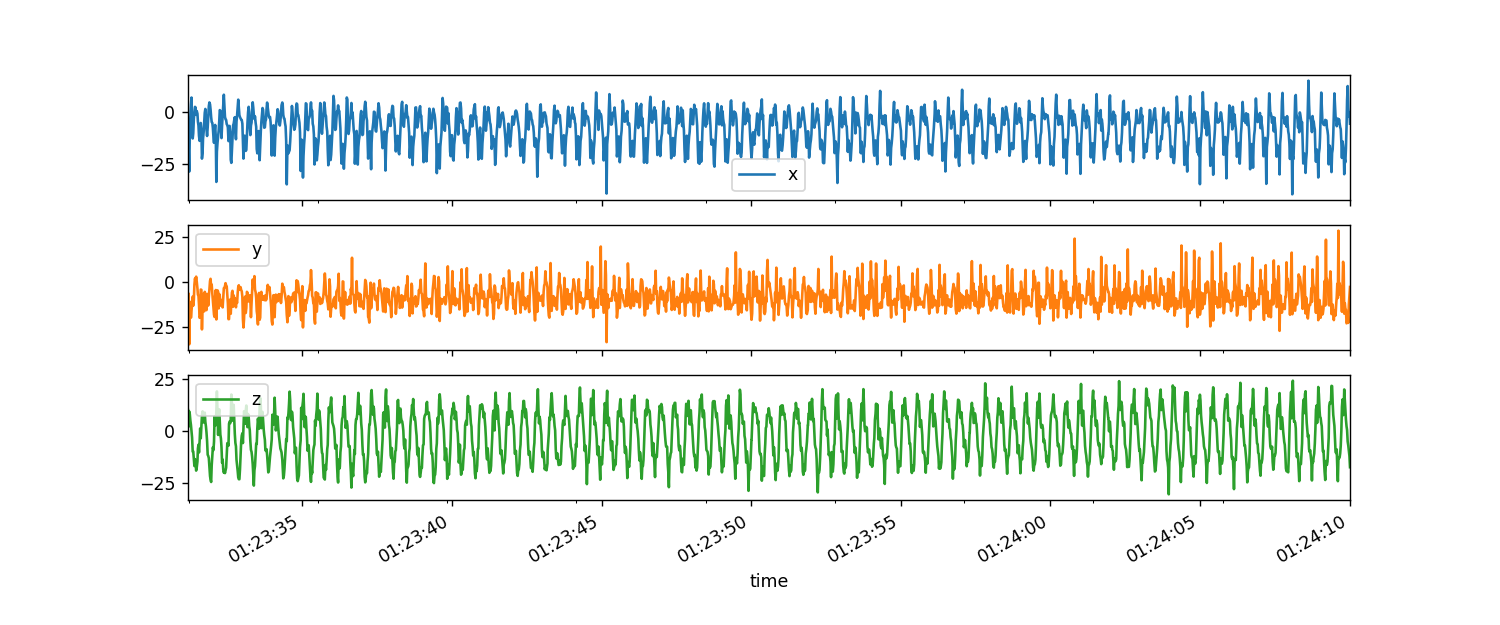

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ABF8FE1BC8>,
      dtype=object)

In [51]:
jump_fast.plot(x='time', subplots=True)

<IPython.core.display.Javascript object>


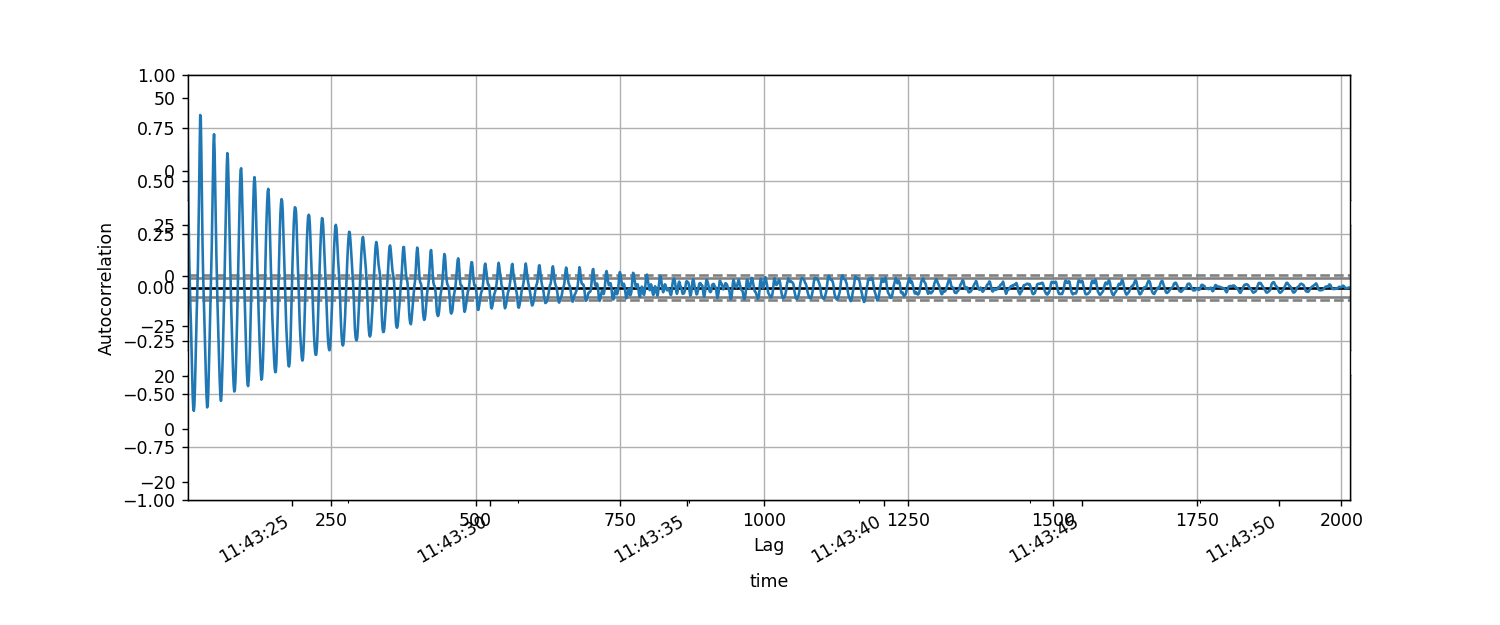

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ABF8FDD808>,
      dtype=object)

In [52]:
jump_fast_right.plot(x='time', subplots=True)

#### number of turns

<IPython.core.display.Javascript object>


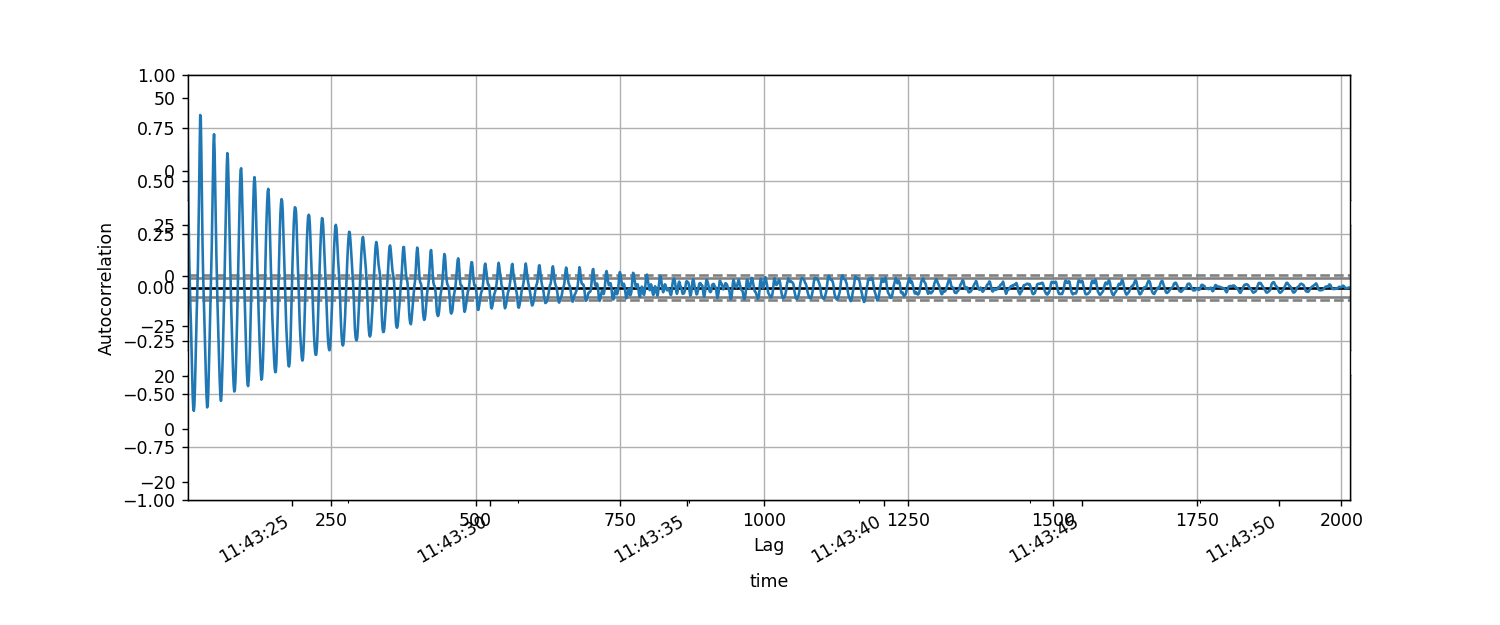

In [53]:
#autocorrelation
'''
corrMax = (0,0)
for l in range(1,5):
    corr = jump_fast["x"].autocorr(lag=l)
    if corr > corrMax[0]:
        corrMax = (corr, l)
print(corrMax)'''

ax = pd.plotting.autocorrelation_plot(jump_fast["x"])
ax.figure

In [54]:
#scipy corelate
corr = correlate(jump_fast["x"], jump_fast["x"], mode="same")
plt.plot(corr)

154


<IPython.core.display.Javascript object>


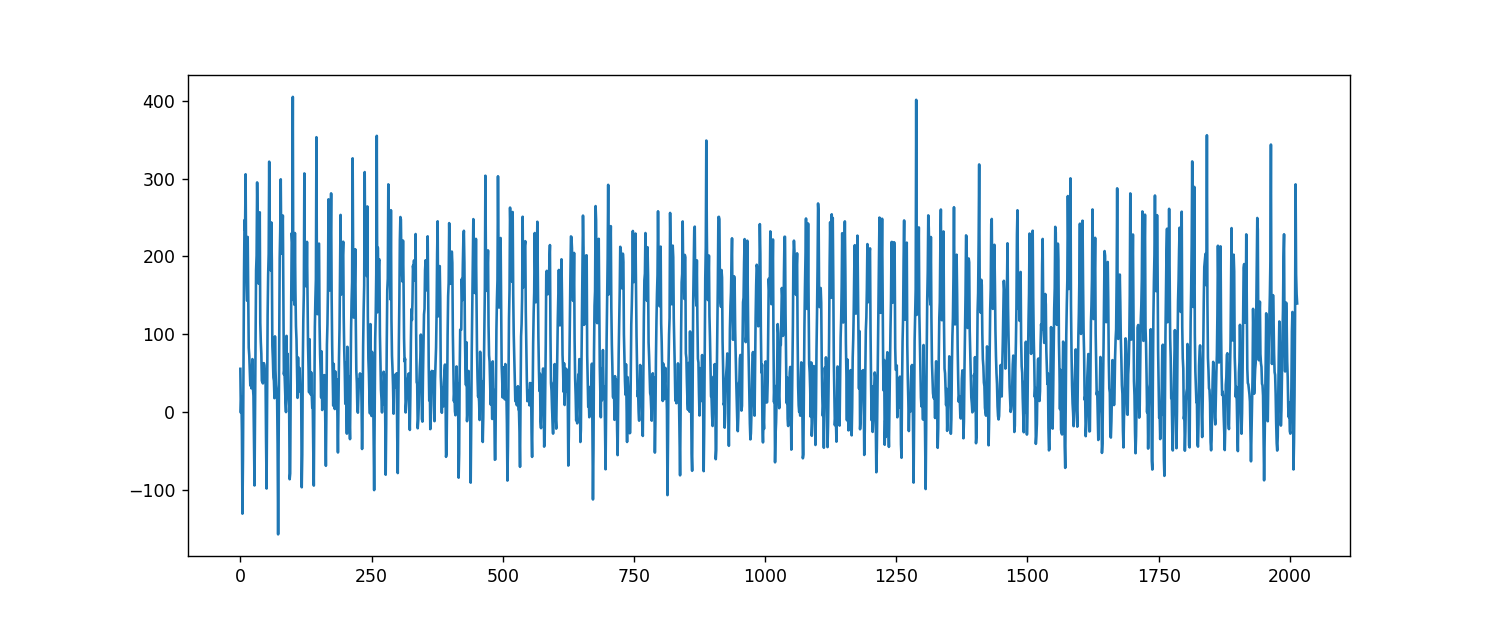

In [55]:
'''
for i in range(1,10):
    period = jump_fast["x"].iloc[0:i]
    plt.plot(correlate(period, jump_fast["x"]))'''
period = jump_fast["x"].iloc[10:11]
print(find_peaks(correlate(period, jump_fast["x"]),  height = 200)[0].size)
plt.figure()
plt.plot(correlate(period, jump_fast["x"]))

In [56]:
#segmentation + feature extraction
jump_fast = feature_extraction_segmentation(jump_fast,1, True)
jump_fast2 = feature_extraction_segmentation(jump_fast2,1, True)
jump_fast_right = feature_extraction_segmentation(jump_fast_right,1, True)
jump_fast_right

x_mean     y_mean    z_mean      x_min      y_min      z_min  \
0    5.575415  -8.393746 -4.724490  -7.255038 -28.948368 -19.070797   
1    4.401884  -8.251936 -4.589577  -3.536592 -28.948368 -13.773088   
2    5.955266  -7.463120 -5.705381  -5.326423 -23.578875 -12.174682   
3    7.631724  -8.984405 -6.940612  -9.092726 -23.578875 -14.294723   
4    7.974220  -8.758099 -5.850589 -15.641882 -26.565117 -15.448063   
5    8.379757  -7.889780 -4.402011 -15.641882 -26.565117 -15.448063   
6    7.153711  -7.737974 -3.823178  -8.398808 -23.880369 -14.440684   
7    5.342069  -8.050698 -4.137651  -8.398808 -27.972097 -12.983456   
8    5.079963  -7.277724 -5.299366  -2.907279 -27.972097 -12.983456   
9    6.519614  -7.171842 -6.996613  -6.793223 -29.625538 -11.947364   
10   7.215695  -8.709552 -6.315027  -9.250652 -29.625538 -12.890136   
11   7.609223  -8.982234 -3.414558  -9.250652 -25.375885 -12.890136   
12   6.849009  -8.419029 -3.379839  -3.081956 -25.375885 -10.566705   
13   5.294902  -8.501423 -4.602272  -4.400401 -21.786650 -10.566705   
14   4.472324  -9.651220 -5.034683  -4.400401 -29.967710 -11.009377   
15   2.975981  -8.795418 -4.394925  -5.285745 -29.967710 -12.854243   
16   2.902034  -8.155108 -3.931454  -5.534599 -23.456841 -12.854243   
17   4.720763  -9.401216 -3.907249  -5.534599 -29.005796 -13.284951   
18   5.587149 -10.109031 -3.301911  -4.955536 -29.005796 -13.284951   
19   5.855973 -10.440667 -2.943862  -4.955536 -24.583860 -14.127225   
20   5.277785  -8.806830 -3.686926  -3.299702 -24.583860 -14.127225   
21   4.799726  -7.563897 -4.813531  -5.151747 -20.578276 -13.852050   
22   5.288644  -9.448474 -4.923877  -5.151747 -24.624538 -13.787444   
23   5.349983  -9.630927 -4.869486  -4.625326 -24.624538 -12.562319   
24   5.110084  -8.081923 -4.906976  -4.252046 -21.992434 -13.237095   
25   4.694474  -8.164750 -5.527127  -4.412365 -23.995226 -14.802001   
26   5.423380  -9.116319 -5.818435  -8.169097 -25.753950 -14.802001   
27   5.399864  -9.372824 -5.755935  -8.169097 -25.753950 -15.828522   
28   4.882187  -8.708172 -5.782670  -4.972285 -26.641687 -15.828522   
29   5.830849  -8.469074 -6.418977  -3.749553 -26.641687 -14.696716   
30   5.003760  -7.856971 -6.870300  -4.761717 -32.566315 -16.134804   
31   4.772715  -7.020726 -5.375430  -5.458028 -32.566315 -16.134804   
32   6.316914  -7.263413 -4.659102 -11.349157 -29.187651 -17.481962   
33   6.130043  -8.222659 -4.857660 -11.349157 -23.018953 -17.481962   
34   6.831649  -9.121158 -5.251073  -4.390830 -28.692337 -23.129025   
35   8.135550  -8.323504 -5.344158  -5.192425 -28.692337 -23.129025   
36   6.838503  -8.149816 -4.724214  -5.192425 -25.115067 -11.325230   
37   5.752070  -9.375309 -5.149400  -4.316652 -29.893534 -13.170095   
38   5.346946  -7.690670 -4.288628  -4.316652 -29.893534 -13.170095   
39   5.561334  -7.233089 -3.295193  -1.418944 -18.484554 -11.956935   
40   7.191168  -7.832951 -4.743679  -5.685347 -20.985054 -11.956935   
41   8.972487  -7.743542 -5.985278  -5.685347 -29.675787 -19.743179   
42  11.244886  -8.634224 -5.817182  -4.694718 -29.675787 -21.664616   
43  11.783547  -8.012229 -4.377163   0.784846 -25.048067 -21.664616   
44  11.314094  -7.836954 -3.292524  -7.211967 -32.891739 -18.951155   
45  13.340925  -8.140899 -4.128511  -7.211967 -32.891739 -24.576681   
46  14.042004  -7.921807 -3.933662  -5.613562 -26.933611 -24.576681   
47  13.561552  -7.124353 -2.381043  -0.344566 -34.018761 -24.564716   
48  12.791795  -6.706894 -2.258590  -0.894916 -34.018761 -23.389841   
49  11.341841  -9.279780 -2.405155  -3.290131 -28.709085 -17.836100   
50   8.326056  -9.462647 -2.120041  -6.101698 -28.709085 -17.836100   
51   6.252722  -8.396553 -1.086664  -6.101698 -20.087746  -6.841080   
52   6.979496  -9.988516 -1.621091  -3.859623 -30.309885 -11.303694   
53   8.068736 -10.234056 -2.627917 -15.835700 -30.800413 -14.196617   
54   7.509552  -9.123971 -1.590353 -15.835700 -30.800413 -14.196617   
55   5.788146  -9.124385 -0.959

In [58]:
jump_fast = pd.concat([jump_fast, jump_fast2, jump_fast_right], ignore_index=True)
jump_fast

x_mean     y_mean    z_mean      x_min      y_min      z_min  \
0   -7.228395  -9.667924 -3.918707 -33.757942 -34.614571 -24.646072   
1   -7.250713  -9.278998 -3.926530 -33.757942 -20.800808 -24.646072   
2   -7.214222  -9.482204 -3.954277 -24.504896 -25.277779 -23.320450   
3   -6.844761  -9.556749 -3.428501 -23.229523 -25.277779 -26.388048   
4   -5.984311  -9.608149 -3.026598 -23.229523 -23.633909 -26.388048   
..        ...        ...       ...        ...        ...        ...   
203  6.979496  -9.988516 -1.621091  -3.859623 -30.309885 -11.303694   
204  8.068736 -10.234056 -2.627917 -15.835700 -30.800413 -14.196617   
205  7.509552  -9.123971 -1.590353 -15.835700 -30.800413 -14.196617   
206  5.788146  -9.124385 -0.959752  -3.086741 -22.784458  -9.296116   
207  6.604237  -9.519845 -0.671325  -3.086741 -22.784458  -9.296116   

         x_max      y_max      z_max      x_std  ...     x_med      y_med  \
0     7.200003   2.964707  19.188046   8.437594  ... -6.254838  -8.282756   
1     8.568698   1.763510  19.188046   8.153235  ... -6.390033  -8.519645   
2     8.568698  -0.648455  17.680567   7.438783  ... -6.205785  -8.786445   
3     6.173482   3.256632  16.041483   7.076625  ... -5.270192  -8.397610   
4     4.886144   3.256632  16.151552   6.873370  ... -4.944768  -8.927622   
..         ...        ...        ...        ...  ...       ...        ...   
203  38.880974  -0.387637  11.887543   8.753807  ...  4.344169  -9.729217   
204  38.880974  18.556339  14.581861  10.654845  ...  6.313462 -10.275976   
205  31.293335  18.556339  14.581861  10.005577  ...  4.315456  -9.692128   
206  31.293335   3.553342  11.456835   8.099776  ...  3.268595  -9.337991   
207  32.805599  -0.665205  14.246866   8.053846  ...  5.277370  -8.496913   

        z_med   activity        sma         smv      tilt        x_psd  \
0   -4.201797  jump_fast  27.890787  966.782724  1.973895  6347.826863   
1   -4.266402  jump_fast  28.165639  967.516698  1.976972  6124.024754   
2   -2.971885  jump_fast  27.974581  958.522397  1.996550  5528.450147   
3   -1.201197  jump_fast  26.975532  929.225813  1.988400  4990.249044   
4   -0.831506  jump_fast  25.556128  877.931615  1.928550  4271.627315   
..        ...        ...        ...         ...       ...          ...   
203 -3.000599  jump_fast  22.379518  761.921337  1.161292  6441.180764   
204 -3.195615  jump_fast  27.037469  908.190371  1.157028  9175.245429   
205 -2.127219  jump_fast  24.916600  851.094100  1.144184  8038.145126   
206 -1.794617  jump_fast  20.429229  713.362476  1.205830  5088.062137   
207 -1.794617  jump_fast  21.546540  736.885165  1.147692  5576.115151   

           y_psd        z_psd  
0    7744.586684  6575.937258  
1    6168.176365  7670.161531  
2    6401.503863  7611.918697  
3    6862.738361  7158.306985  
4    6735.994820  6065.293078  
..           ...          ...  
203  6977.002441  1699.307483  
204  9660.091033  2312.176266  
205  8551.190107  2023.648037  
206  6344.951171  1466.158392  
207  6300.410622  1713.663019  

[208 rows x 22 columns]

## jump_slow

In [59]:
jump_slow = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow.csv", sep=';', header=0, skipinitialspace=True)
jump_slow2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow1 (meting2).csv", sep=';', header=0, skipinitialspace=True)
jump_slow_rigth = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow_tim.csv", sep=';', header=0, skipinitialspace=True)

jump_slow = preprocess(jump_slow, "jump_slow")
jump_slow2 = preprocess(jump_slow2, "jump_slow")
jump_slow_rigth = preprocess(jump_slow_rigth, "jump_slow")

jump_slow_rigth

time         x          y         z   activity
244  1970-01-01 11:39:31.325902848  3.577270  -9.265009 -6.453443  jump_slow
245  1970-01-01 11:39:31.342680064  3.527021 -10.573883 -6.137590  jump_slow
246  1970-01-01 11:39:31.363651584  3.637090 -11.598011 -6.494121  jump_slow
247  1970-01-01 11:39:31.384623104  3.072384 -11.724831 -6.726224  jump_slow
248  1970-01-01 11:39:31.401400320  2.833102 -11.432906 -6.855437  jump_slow
...                            ...       ...        ...       ...        ...
2096 1970-01-01 11:40:07.069761536  8.511271  -5.166104  7.082755  jump_slow
2097 1970-01-01 11:40:07.090733056  9.643075  -4.874180  8.207381  jump_slow
2098 1970-01-01 11:40:07.107510272  9.415757  -3.905087  8.712267  jump_slow
2099 1970-01-01 11:40:07.128481792  9.008977  -3.177669  8.020741  jump_slow
2100 1970-01-01 11:40:07.149453312  8.647661  -3.457629  8.767303  jump_slow

[1856 rows x 5 columns]

<IPython.core.display.Javascript object>


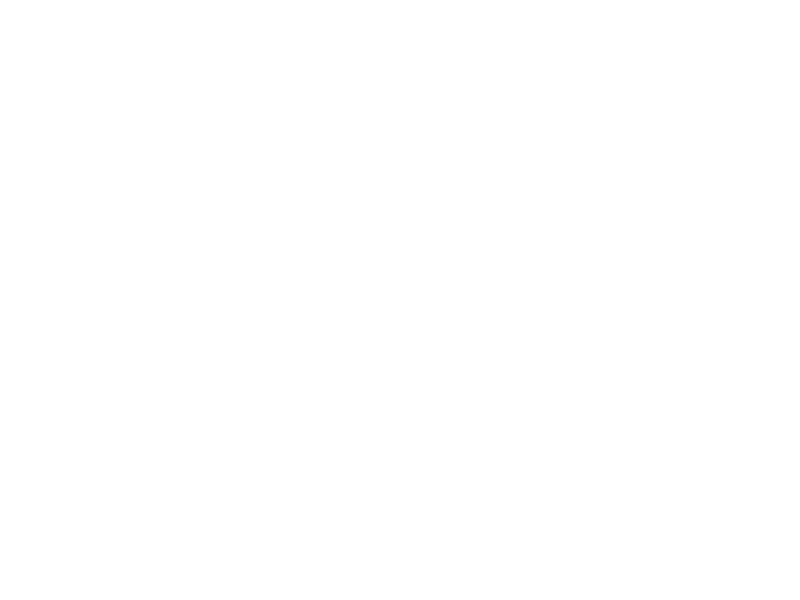

C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matpl

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ABF41A9D88>,
      dtype=object)

In [18]:
jump_slow.plot(x='time', subplots=True)

<IPython.core.display.Javascript object>


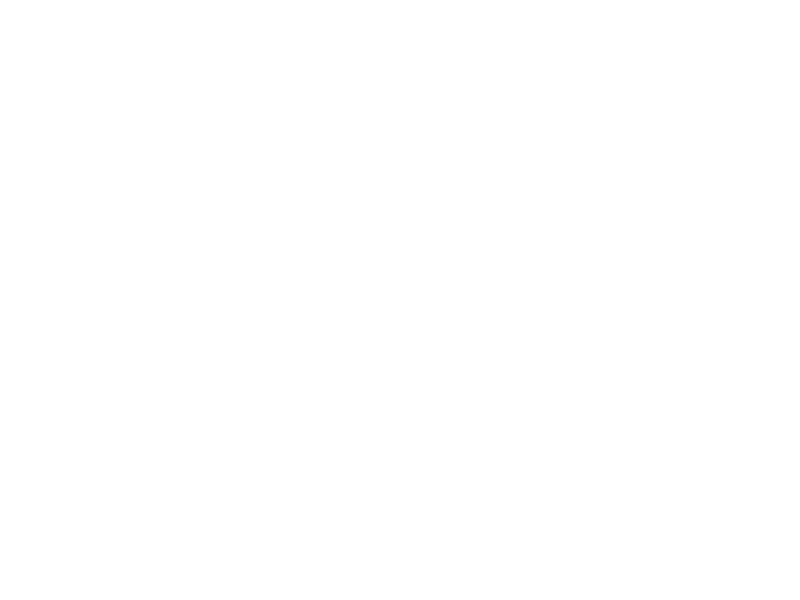

C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matpl

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ABF5488108>,
      dtype=object)

In [19]:
jump_slow_rigth.plot(x='time', subplots=True)

In [20]:
turns_x = get_number_of_turns(jump_slow2[['time','x']], "x", 0.183)
turns_y = get_number_of_turns(jump_slow2[['time','y']], "y", 0.183)
turns_z = get_number_of_turns(jump_slow2[['time','z']], "z", 0.183)

(turns_x + turns_y + turns_z)/3

NameError: name 'get_number_of_turns' is not defined

<IPython.core.display.Javascript object>


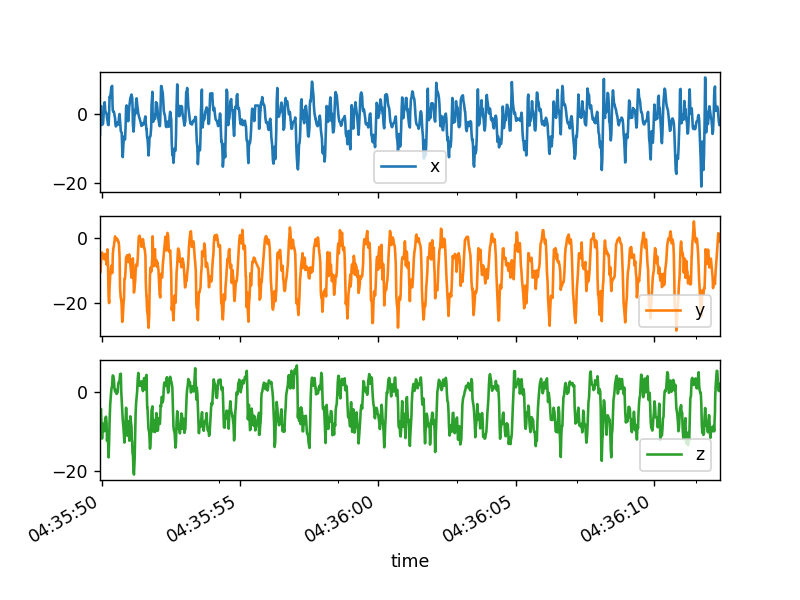

C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matpl

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ABF55B0688>,
      dtype=object)

In [21]:
jump_slow2.plot(x='time', subplots=True)

### differences between hands

In [22]:
jump_slow_right = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow_right2.csv", sep=';', header=0, skipinitialspace=True)

jump_slow_right = preprocess(jump_slow_right, "jump_slow")

jump_slow_right

time          x          y         z   activity
156  1970-01-01 06:03:48.898168832  -4.953143 -14.878572  1.787439  jump_slow
157  1970-01-01 06:03:48.914946048  -4.240082 -13.222738  3.012564  jump_slow
158  1970-01-01 06:03:48.933820416  -8.599805  -9.298509  2.076970  jump_slow
159  1970-01-01 06:03:48.956889088  -8.432307  -6.472585  1.373480  jump_slow
160  1970-01-01 06:03:48.973666304  -3.282953  -5.137390  1.887937  jump_slow
...                            ...        ...        ...       ...        ...
2574 1970-01-01 06:04:35.526246400  12.643675 -17.874386  2.098505  jump_slow
2575 1970-01-01 06:04:35.557703680  15.239887 -17.785851  2.883351  jump_slow
2576 1970-01-01 06:04:35.568189440  15.187245 -21.001804  1.741975  jump_slow
2577 1970-01-01 06:04:35.584966656  14.062618 -20.618952  0.533599  jump_slow
2578 1970-01-01 06:04:35.603841024  12.600604 -21.568903 -1.785046  jump_slow

[2423 rows x 5 columns]

<IPython.core.display.Javascript object>


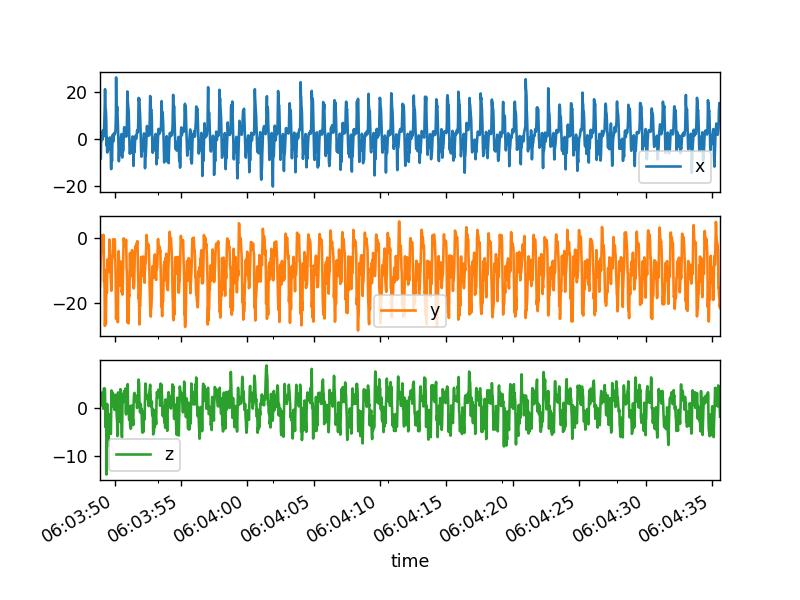

C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matpl

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ABF5B0B388>,
      dtype=object)

In [23]:
jump_slow_right.plot(x='time', subplots=True)

In [24]:
jump_slow = jump_slow.reset_index(drop=True)
jump_slow2 = jump_slow2.reset_index(drop=True)
diff_left = jump_slow.loc[:,'x':'z'] - jump_slow2.loc[:,'x':'z']
diff_left['time'] =  jump_slow['time']
diff_left

x         y         z                          time
0     11.758330  2.084148  6.635297 1970-01-01 01:22:43.384205312
1     -1.603191  5.201997  3.110669 1970-01-01 01:22:43.403997184
2     -7.085148 -0.375672  1.024128 1970-01-01 01:22:43.422347264
3     -5.491528 -4.807180  2.000399 1970-01-01 01:22:43.442663424
4     -4.113262 -3.314060  2.636890 1970-01-01 01:22:43.461931008
...         ...       ...       ...                           ...
1768        NaN       NaN       NaN 1970-01-01 01:23:17.489008640
1769        NaN       NaN       NaN 1970-01-01 01:23:17.509193728
1770        NaN       NaN       NaN 1970-01-01 01:23:17.528461312
1771        NaN       NaN       NaN 1970-01-01 01:23:17.548122112
1772        NaN       NaN       NaN 1970-01-01 01:23:17.566734336

[1773 rows x 4 columns]

### different turn direction

In [25]:
jump_slow_turn_diff = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow_turn_diff.csv", sep=';', header=0, skipinitialspace=True)

jump_slow_turn_diff = preprocess(jump_slow_turn_diff, "jump_slow")

jump_slow_turn_diff

time         x         y         z   activity
210  1970-01-01 11:26:39.901122560 -1.454836  1.488336 -1.995614  jump_slow
211  1970-01-01 11:26:39.922094080 -2.545963  1.538585 -1.689333  jump_slow
212  1970-01-01 11:26:39.938871296 -1.392623  2.402394 -1.179662  jump_slow
213  1970-01-01 11:26:39.959842816 -1.397408  3.134598 -1.751546  jump_slow
214  1970-01-01 11:26:39.976620032 -2.775674  2.340181 -1.962115  jump_slow
...                            ...       ...       ...       ...        ...
3056 1970-01-01 11:27:34.825533440  1.172483 -8.193025 -0.296710  jump_slow
3057 1970-01-01 11:27:34.846504960  1.045663 -7.298109 -0.512064  jump_slow
3058 1970-01-01 11:27:34.867476480  1.057628 -7.628319 -1.689333  jump_slow
3059 1970-01-01 11:27:34.884253696  1.186840 -8.556734 -3.323631  jump_slow
3060 1970-01-01 11:27:34.905225216  1.416551 -8.401200 -3.969693  jump_slow

[2850 rows x 5 columns]

<IPython.core.display.Javascript object>


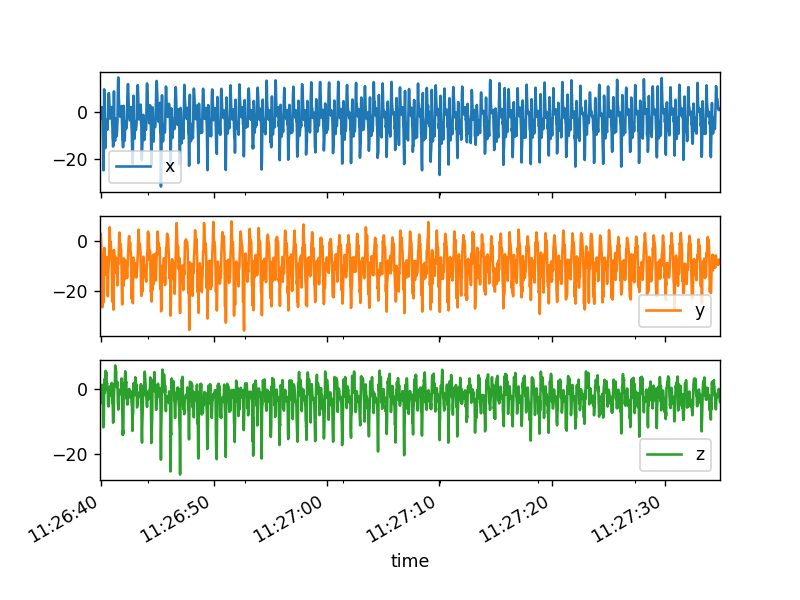

C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matpl

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ABF5B0D5C8>,
      dtype=object)

In [26]:
jump_slow_turn_diff.plot(x='time', subplots=True)

### segmentation

In [60]:
#segmentation + feature extraction
jump_slow =  feature_extraction_segmentation(jump_slow,1, True)
jump_slow2 =  feature_extraction_segmentation(jump_slow2,1, True)
jump_slow_rigth = feature_extraction_segmentation(jump_slow_rigth,1, True)

jump_slow_rigth

x_mean     y_mean    z_mean      x_min      y_min      z_min      x_max  \
0   6.388192  -8.929646 -3.369186 -10.133604 -22.872992 -24.961926  23.413769   
1   3.994863 -11.394437 -1.608437 -10.133604 -23.686552 -23.217558  23.413769   
2   4.860237  -8.948420 -2.434835 -10.669596 -29.032118 -23.217558  27.818956   
3   4.882186  -8.967333 -0.865604 -10.669596 -29.032118 -13.545769  27.818956   
4   4.436017  -9.661528 -2.011121 -22.798815 -24.454647 -13.545769  34.916069   
..       ...        ...       ...        ...        ...        ...        ...   
65  4.804098  -9.827553 -1.504303 -19.140188 -25.136602 -11.423335  38.723049   
66  4.498829 -10.801017 -1.776395 -19.140188 -25.136602 -11.423335  32.870205   
67  3.326023  -7.967087 -2.116728 -15.091533 -21.901506 -11.215159  32.870205   
68  4.009726  -9.642155 -2.913676 -30.678379 -22.437498 -11.215159  39.948174   
69  3.313967  -9.491775 -0.970152 -30.678379 -22.437498 -10.377672  39.948174   

       y_max      z_max      x_std  ...     x_med      y_med     z_med  \
0   3.163311  12.043077   6.577216  ...  6.393622 -10.546366  0.198604   
1  -2.754139  12.043077   6.515867  ...  2.941975 -10.606186 -0.628116   
2   5.850451   9.628718   7.004845  ...  3.600002  -9.363114 -1.624726   
3   5.850451   9.628718   7.407916  ...  3.214757 -10.335798 -1.325624   
4   3.704089   4.441079   9.572077  ...  1.834099 -10.399207 -1.501496   
..       ...        ...        ...  ...       ...        ...       ...   
65  5.285745  14.459827   9.697254  ...  4.016352 -10.880164 -1.069592   
66  4.161119  14.459827  11.305885  ...  2.823531 -12.427124 -2.939583   
67  4.797609  11.026127   9.229273  ...  1.740779  -8.955139 -2.609373   
68  4.797609   6.309873  10.692794  ...  2.368895 -10.746167 -3.040081   
69  2.904887   6.309873  10.940396  ...  0.831506  -9.353544 -0.468993   

     activity        sma         smv      tilt        x_psd        y_psd  \
0   jump_slow  25.155745  855.375022  1.101268  4328.316543  5842.411004   
1   jump_slow  23.127965  792.177656  1.280990  2995.147283  8177.450013   
2   jump_slow  21.787202  750.334613  1.187594  3730.799156  8787.392568   
3   jump_slow  20.747705  724.021478  1.189950  4038.196665  8774.387068   
4   jump_slow  20.343870  726.551848  1.252582  5696.126635  8053.337633   
..        ...        ...         ...       ...          ...          ...   
65  jump_slow  23.394305  800.384522  1.301992  5995.999558  8098.025505   
66  jump_slow  25.388538  854.848677  1.372145  7571.427039  8919.359101   
67  jump_slow  19.848372  688.053237  1.379963  4919.399664  6907.991015   
68  jump_slow  21.332244  764.354425  1.310682  6667.179064  7939.382886   
69  jump_slow  19.270091  690.563483  1.372257  6675.389205  6904.655478   

          z_psd  
0   5785.149260  
1   3316.671210  
2   2952.829902  
3   1432.031232  
4   1126.292787  
..          ...  
65  2343.504454  
66  2146.898141  
67  1607.625363  
68  1364.949161  
69   879.160019  

[70 rows x 22 columns]

In [61]:
jump_slow = pd.concat([jump_slow, jump_slow2, jump_slow_rigth], ignore_index=True)
jump_slow

x_mean     y_mean    z_mean      x_min      y_min      z_min  \
0   -5.701728  -8.716455 -4.406751 -25.507490 -23.327627 -20.379671   
1   -6.583529  -7.798393 -3.712556 -25.507490 -23.327627 -20.358135   
2   -5.490792  -8.849302 -4.559063 -20.236101 -22.377678 -20.358135   
3   -5.796429  -9.264871 -2.538095 -20.236101 -22.377678 -19.769501   
4   -5.784649  -9.522146 -5.488813 -19.051655 -18.788443 -19.769501   
..        ...        ...       ...        ...        ...        ...   
175  4.804098  -9.827553 -1.504303 -19.140188 -25.136602 -11.423335   
176  4.498829 -10.801017 -1.776395 -19.140188 -25.136602 -11.423335   
177  3.326023  -7.967087 -2.116728 -15.091533 -21.901506 -11.215159   
178  4.009726  -9.642155 -2.913676 -30.678379 -22.437498 -11.215159   
179  3.313967  -9.491775 -0.970152 -30.678379 -22.437498 -10.377672   

         x_max     y_max      z_max      x_std  ...     x_med      y_med  \
0     6.252446  3.897908  12.571890   7.021966  ... -4.776074  -8.723035   
1     6.252446  2.215754  12.571890   6.926686  ... -6.313462  -8.982657   
2     5.307281  1.708475  10.502099   6.350705  ... -5.455636  -9.430114   
3     4.618148  0.631705  10.502099   6.318987  ... -5.166105  -9.558129   
4     5.513063  0.631705   8.906086   6.091900  ... -4.389633 -10.095319   
..         ...       ...        ...        ...  ...       ...        ...   
175  38.723049  5.285745  14.459827   9.697254  ...  4.016352 -10.880164   
176  32.870205  4.161119  14.459827  11.305885  ...  2.823531 -12.427124   
177  32.870205  4.797609  11.026127   9.229273  ...  1.740779  -8.955139   
178  39.948174  4.797609   6.309873  10.692794  ...  2.368895 -10.746167   
179  39.948174  2.904887   6.309873  10.940396  ...  0.831506  -9.353544   

        z_med   activity        sma         smv      tilt        x_psd  \
0   -4.869394  jump_slow  22.648204  749.266591  1.953435  4205.213048   
1   -3.187239  jump_slow  22.135680  736.284011  2.101431  4700.756868   
2   -3.517450  jump_slow  22.571956  745.833087  1.963717  3624.641637   
3   -1.613959  jump_slow  21.987463  724.389573  2.017063  3783.535887   
4   -5.079963  jump_slow  23.324269  760.452677  1.993172  3632.705800   
..        ...        ...        ...         ...       ...          ...   
175 -1.069592  jump_slow  23.394305  800.384522  1.301992  5995.999558   
176 -2.939583  jump_slow  25.388538  854.848677  1.372145  7571.427039   
177 -2.609373  jump_slow  19.848372  688.053237  1.379963  4919.399664   
178 -3.040081  jump_slow  21.332244  764.354425  1.310682  6667.179064   
179 -0.468993  jump_slow  19.270091  690.563483  1.372257  6675.389205   

           y_psd        z_psd  
0    6298.109701  3523.776282  
1    5746.858166  3410.594314  
2    5789.259428  3745.541650  
3    6295.161371  3216.795198  
4    6394.195930  4423.885807  
..           ...          ...  
175  8098.025505  2343.504454  
176  8919.359101  2146.898141  
177  6907.991015  1607.625363  
178  7939.382886  1364.949161  
179  6904.655478   879.160019  

[180 rows x 22 columns]

## side swing

In [62]:
side_swing = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\side_swing.csv", sep=';', header=0, skipinitialspace=True)
side_swing2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\side_swing2 (meting2).csv", sep=';', header=0, skipinitialspace=True)
side_swing3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\side_swing3 (meting2).csv", sep=';', header=0, skipinitialspace=True)
side_swing_rigth = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\side_swing_tim.csv", sep=';', header=0, skipinitialspace=True)

side_swing = preprocess(side_swing, "side_swing")
side_swing2 = preprocess(side_swing2, "side_swing")
side_swing3 = preprocess(side_swing3, "side_swing")
side_swing_rigth = preprocess(side_swing_rigth, "side_swing")

side_swing_rigth

time         x         y         z    activity
277  1970-01-01 11:40:23.184277504  1.533799 -1.296910  7.281359  side_swing
278  1970-01-01 11:40:23.201054720  1.016950 -1.787439  6.690332  side_swing
279  1970-01-01 11:40:23.222026240  0.892523 -2.048256  6.501299  side_swing
280  1970-01-01 11:40:23.242997760  2.074577 -2.754139  6.407979  side_swing
281  1970-01-01 11:40:23.259774976  3.550949 -3.991228  6.597012  side_swing
...                            ...       ...       ...       ...         ...
2921 1970-01-01 11:41:14.220568576  0.318245 -3.242275  1.488336  side_swing
2922 1970-01-01 11:41:14.237345792  0.784846 -4.785645  1.488336  side_swing
2923 1970-01-01 11:41:14.258317312  1.107877 -5.321638  1.682154  side_swing
2924 1970-01-01 11:41:14.275094528  1.244268 -5.934200  2.050649  side_swing
2925 1970-01-01 11:41:14.296066048  1.799403 -7.046863  2.258825  side_swing

[2649 rows x 5 columns]

<IPython.core.display.Javascript object>


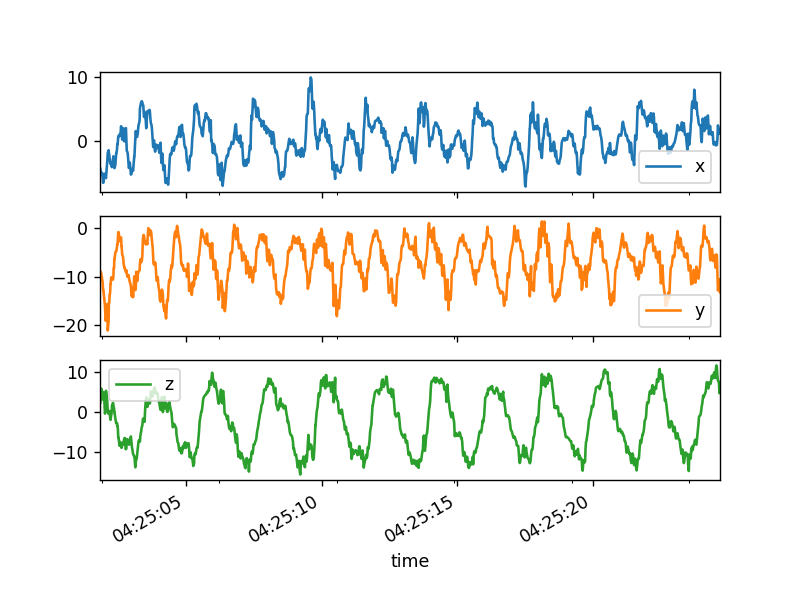

C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matpl

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ABF6573908>,
      dtype=object)

In [30]:
side_swing.plot(x='time', subplots=True)

<IPython.core.display.Javascript object>


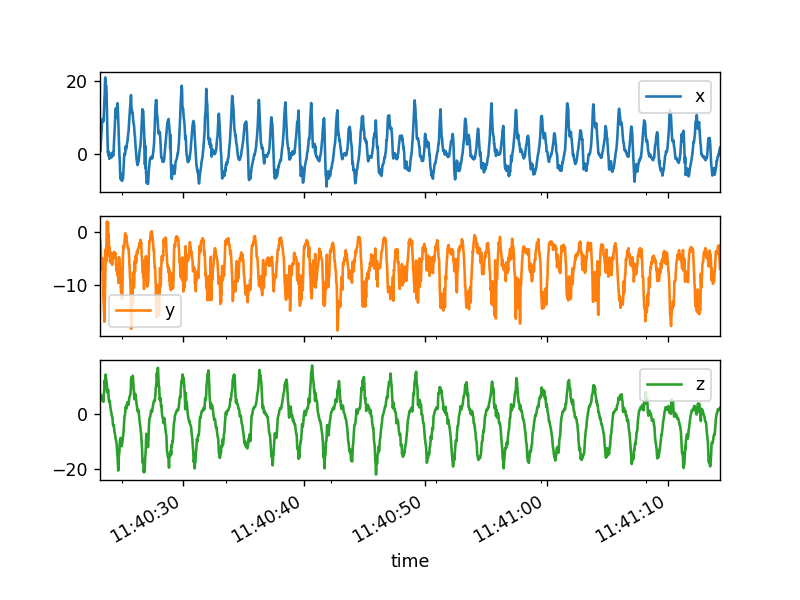

C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matpl

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ABF6688748>,
      dtype=object)

In [31]:
side_swing_rigth.plot(x='time', subplots=True)

In [63]:
#segmentation + feature extraction
side_swing =  feature_extraction_segmentation(side_swing,1, True)
side_swing2 =  feature_extraction_segmentation(side_swing2,1, True)
side_swing3 =  feature_extraction_segmentation(side_swing3,1, True)
side_swing_rigth =  feature_extraction_segmentation(side_swing_rigth,1, True)

side_swing_rigth

x_mean    y_mean    z_mean     x_min      y_min      z_min      x_max  \
0    6.747576 -5.233195  6.776060 -1.258625 -17.060825  -0.813560  20.946770   
1    5.278889 -4.071756 -1.277537 -1.258625  -8.322237 -19.377077  18.630518   
2    2.054054 -6.476359 -9.364173 -7.252645 -12.658031 -20.523239  13.935799   
3    0.769753 -5.264394 -3.624574 -7.252645 -12.658031 -20.523239  12.866207   
4    6.573222 -6.489841  6.324460 -0.227318 -18.415163  -1.648655  16.149160   
..        ...       ...       ...       ...        ...        ...        ...   
96  -1.041890 -5.848657 -6.716515 -6.010770  -9.576077 -19.597218   6.412765   
97   3.024988 -8.892235  0.717433 -6.010770 -15.644275  -7.501499  10.652846   
98   3.492003 -9.648735  0.686694 -1.610370 -15.644275  -4.771288  10.652846   
99   0.005844 -5.782946 -6.981152 -5.793024 -13.057633 -19.010977   4.431508   
100 -1.300545 -5.808577 -8.370278 -5.793024  -9.879965 -19.010977   4.431508   

        y_max      z_max     x_std  ...     x_med      y_med     z_med  \
0    1.971686  14.397614  7.188110  ...  5.580063  -5.035695  6.454639   
1    1.971686  12.892529  6.231910  ...  2.036292  -4.524828 -0.855434   
2   -2.612962  -0.897308  7.188989  ...  0.256032  -6.116054 -9.154940   
3   -0.260818   6.900900  5.825567  ...  1.027718  -4.400401 -2.179861   
4   -0.260818  13.962120  4.820914  ...  5.955736  -5.583652  5.972485   
..        ...        ...       ...  ...       ...        ...       ...   
96  -2.868994   3.019742  3.900698  ... -2.065006  -5.770292 -7.373483   
97  -2.868994   3.854837  5.205587  ...  3.662215  -9.147761  1.441676   
98  -3.086741   3.854837  4.286574  ...  2.921636 -10.419546  1.122234   
99  -3.086741   1.816152  2.556097  ... -0.485743  -5.146961 -5.288138   
100 -2.825923   1.820938  3.219822  ... -1.624726  -5.021338 -8.589037   

       activity        sma         smv      tilt        x_psd        y_psd  \
0    side_swing  19.389916  650.345779  1.151096  5002.663899  2567.086533   
1    side_swing  16.977629  575.229318  1.221752  3429.738580  1221.515334   
2    side_swing  21.979963  705.151870  1.458430  2855.154561  2561.504109   
3    side_swing  17.091472  545.653229  1.399769  1761.609923  2105.420378   
4    side_swing  19.535878  601.555620  1.008815  3432.078730  3268.700539   
..          ...        ...         ...       ...          ...          ...   
96   side_swing  17.058065  568.314759  1.739953   832.435359  2028.050451   
97   side_swing  16.333315  563.019952  1.447194  1857.833664  5322.690853   
98   side_swing  15.668157  572.072456  1.385810  1571.202633  5851.003375   
99   side_swing  15.226543  557.403126  1.627678   333.216894  1988.365232   
100  side_swing  17.598796  602.683488  1.758752   616.683619  1990.946258   

           z_psd  
0    3077.846665  
1    3602.193877  
2    5653.890659  
3    3704.663670  
4    2953.384108  
..           ...  
96   4990.523884  
97    358.853452  
98    233.072397  
99   5136.731643  
100  5798.626920  

[101 rows x 22 columns]

In [65]:
side_swing  = pd.concat([side_swing, side_swing2, side_swing3, side_swing_rigth], ignore_index=True)
side_swing

x_mean    y_mean    z_mean     x_min      y_min      z_min      x_max  \
0   -1.947006 -8.899796 -2.306510 -6.527620 -21.140589  -9.241081   2.309074   
1   -0.650063 -7.511781 -7.108627 -5.254639 -14.242081 -13.725230   5.515456   
2    1.073801 -6.883132 -3.875221 -5.254639 -14.242081 -13.725230   6.223732   
3    0.355196 -8.086222  2.046047 -6.546763 -18.656837  -4.917251   6.223732   
4   -1.913742 -9.299916 -0.529940 -6.829116 -18.656837 -10.262816   2.380858   
..        ...       ...       ...       ...        ...        ...        ...   
232 -1.041890 -5.848657 -6.716515 -6.010770  -9.576077 -19.597218   6.412765   
233  3.024988 -8.892235  0.717433 -6.010770 -15.644275  -7.501499  10.652846   
234  3.492003 -9.648735  0.686694 -1.610370 -15.644275  -4.771288  10.652846   
235  0.005844 -5.782946 -6.981152 -5.793024 -13.057633 -19.010977   4.431508   
236 -1.300545 -5.808577 -8.370278 -5.793024  -9.879965 -19.010977   4.431508   

        y_max     z_max     x_std  ...     x_med      y_med     z_med  \
0   -0.789631  5.790631  2.445014  ... -2.103291  -8.925229 -0.492921   
1   -0.789631  0.964308  2.580337  ...  0.023928  -8.291130 -7.448857   
2    0.035892  5.663811  3.616835  ...  1.779064  -7.472785 -5.997610   
3    0.035892  6.022735  3.853150  ... -0.421137  -7.269395  2.325824   
4    0.516850  6.022735  2.406607  ... -1.485943 -10.504492  0.897308   
..        ...       ...       ...  ...       ...        ...       ...   
232 -2.868994  3.019742  3.900698  ... -2.065006  -5.770292 -7.373483   
233 -2.868994  3.854837  5.205587  ...  3.662215  -9.147761  1.441676   
234 -3.086741  3.854837  4.286574  ...  2.921636 -10.419546  1.122234   
235 -3.086741  1.816152  2.556097  ... -0.485743  -5.146961 -5.288138   
236 -2.825923  1.820938  3.219822  ... -1.624726  -5.021338 -8.589037   

       activity        sma         smv      tilt        x_psd        y_psd  \
0    side_swing  15.427929  781.461873  1.739422   677.846726  7235.348931   
1    side_swing  16.833732  714.095217  1.630403   446.507987  4446.869407   
2    side_swing  16.324899  565.227327  1.271704   755.583999  3601.683425   
3    side_swing  14.216311  531.130888  1.314567   763.745651  5218.669744   
4    side_swing  15.154168  576.325786  1.716796   476.370608  5956.644708   
..          ...        ...         ...       ...          ...          ...   
232  side_swing  17.058065  568.314759  1.739953   832.435359  2028.050451   
233  side_swing  16.333315  563.019952  1.447194  1857.833664  5322.690853   
234  side_swing  15.668157  572.072456  1.385810  1571.202633  5851.003375   
235  side_swing  15.226543  557.403126  1.627678   333.216894  1988.365232   
236  side_swing  17.598796  602.683488  1.758752   616.683619  1990.946258   

           z_psd  
0    1774.672110  
1    3906.809855  
2    2655.418674  
3     563.813717  
4    1000.772025  
..           ...  
232  4990.523884  
233   358.853452  
234   233.072397  
235  5136.731643  
236  5798.626920  

[237 rows x 22 columns]

## cross over

In [64]:
#cross_over = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over_slecht.csv", sep=';', header=0, skipinitialspace=True)
cross_over2 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over2.csv", sep=';', header=0, skipinitialspace=True)
cross_over3 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over3.csv", sep=';', header=0, skipinitialspace=True)
cross_over4 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over4.csv", sep=';', header=0, skipinitialspace=True)
cross_over5 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over5.csv", sep=';', header=0, skipinitialspace=True)

#cross_over = preprocess(cross_over, "cross_over")
cross_over2 = preprocess(cross_over2, "cross_over")
cross_over3 = preprocess(cross_over3, "cross_over")
cross_over4 = preprocess(cross_over4, "cross_over")
cross_over5 = preprocess(cross_over5, "cross_over")

cross_over5

time         x          y         z    activity
201 1970-01-01 11:23:59.791955968 -0.600598 -15.239887  3.785445  cross_over
202 1970-01-01 11:23:59.808733184  4.417150 -13.562519  5.352744  cross_over
203 1970-01-01 11:23:59.829704704  6.427122 -15.495919 -0.440279  cross_over
204 1970-01-01 11:23:59.846481920  6.089734 -19.448862  3.113062  cross_over
205 1970-01-01 11:23:59.867453440  3.885944 -14.921642  7.965706  cross_over
..                            ...       ...        ...       ...         ...
783 1970-01-01 11:24:09.975726080 -1.780260  -0.734597  1.227518  cross_over
785 1970-01-01 11:24:09.979920384 -1.780260  -0.734597  1.227518  cross_over
786 1970-01-01 11:24:09.996697600 -0.725025  -4.012764  0.751346  cross_over
787 1970-01-01 11:24:10.013474816 -0.725025  -4.012764  0.751346  cross_over
788 1970-01-01 11:24:10.021863424  1.249053  -3.823730  4.326223  cross_over

[554 rows x 5 columns]

In [35]:
#cross_over.plot(x='time', subplots=True)

<IPython.core.display.Javascript object>


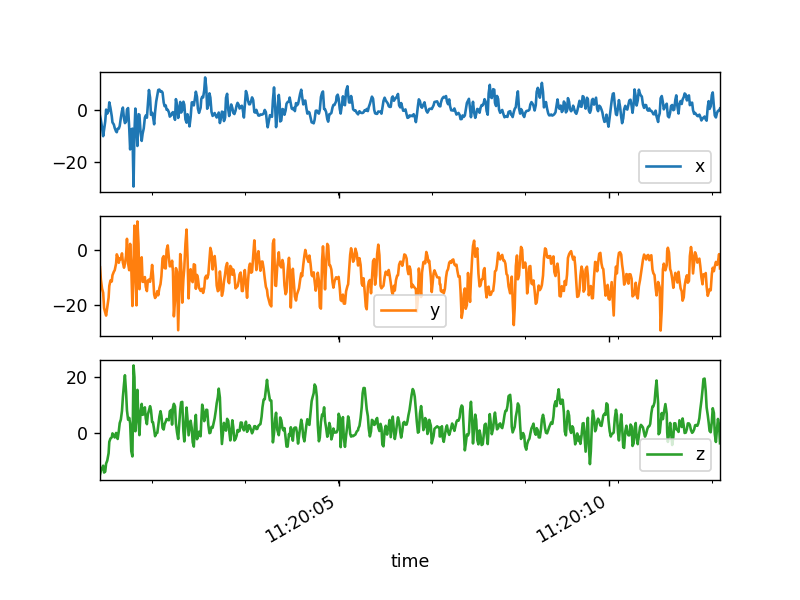

C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matpl

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ABF67D4B48>,
      dtype=object)

In [36]:
cross_over2.plot(x='time', subplots=True)

<IPython.core.display.Javascript object>


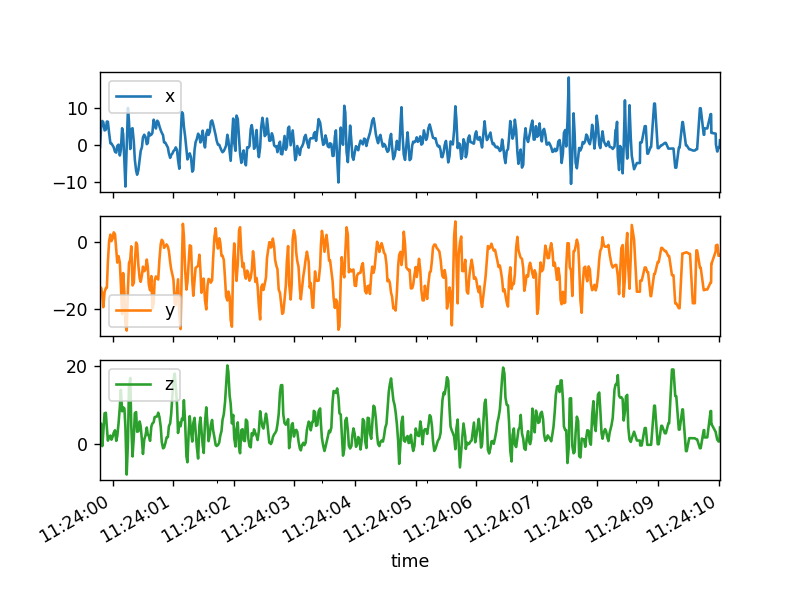

C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matpl

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ABF67E4E08>,
      dtype=object)

In [37]:
cross_over5.plot(x='time', subplots=True)

In [66]:
#segmentation + feature extraction
cross_over2 =  feature_extraction_segmentation(cross_over2,1, True)
cross_over3 =  feature_extraction_segmentation(cross_over3,1, True)
cross_over4 =  feature_extraction_segmentation(cross_over4,1, True)
cross_over5 =  feature_extraction_segmentation(cross_over5,1, True)
cross_over5

x_mean    y_mean    z_mean      x_min      y_min     z_min      x_max  \
0   1.331560 -9.380969  4.544890 -11.215159 -26.455048 -7.724031   9.934999   
1   0.610827 -8.358317  4.780250  -8.030313 -26.005196 -4.577470   8.822337   
2   0.646706 -7.686713  4.101068  -7.211967 -26.005196 -4.577470   8.822337   
3   0.605522 -8.546380  4.191029  -7.211967 -25.299314 -3.622734   7.872386   
4   0.724703 -9.061711  5.066296  -5.508278 -25.299314 -2.268396   7.872386   
5   0.958443 -9.151467  3.969364  -4.110869 -23.136202 -1.536192   7.286145   
6   0.734827 -9.746427  4.931884 -10.119247 -26.220551 -1.682154   6.932007   
7   1.116635 -9.574180  4.276426 -10.119247 -26.220551 -2.885744  10.518848   
8   1.145886 -8.469672  4.057491  -4.646862 -20.449062 -4.974678  10.518848   
9   1.097017 -8.778622  4.257936  -4.110869 -20.449062 -4.974678  10.131211   
10  0.565212 -8.684658  3.714719  -4.721039 -24.897320 -5.893522  10.377672   
11  0.733906 -8.458260  3.564938  -4.721039 -24.897320 -5.893522  10.377672   
12  0.502727 -8.946670  4.162995  -6.111269 -19.379471 -4.374080   6.781260   
13  0.890177 -8.412367  4.761764  -6.111269 -21.461226 -4.374080   6.781260   
14  1.124535 -8.725888  4.571488 -10.499705 -21.461226 -4.773681  18.137596   
15  0.749047 -8.160511  5.350492 -10.499705 -21.128624 -4.773681  18.137596   
16  0.986656 -7.536037  5.675008  -7.652247 -16.278372 -0.617348  11.983255   
17  0.563381 -7.874779  6.091685  -7.652247 -18.307486 -0.275175  11.983255   
18  0.728049 -8.942310  4.426124  -6.135197 -19.752750 -1.725225  11.114661   

       y_max      z_max     x_std  ...     x_med      y_med     z_med  \
0   3.007778  17.008183  4.306837  ...  2.079363  -9.975677  4.319045   
1   5.568098  18.147167  4.020614  ...  0.591027  -8.367701  4.658826   
2   5.568098  18.147167  3.569356  ...  0.666401  -7.862815  3.626323   
3   4.541577  20.214565  3.518696  ...  0.607777  -8.816355  3.626323   
4   4.541577  20.214565  3.303266  ... -0.160320  -8.816355  3.867998   
5   3.632305  15.184853  2.648229  ...  0.485743 -10.037891  3.550949   
6   3.632305  15.184853  2.972397  ...  0.690330 -10.738988  4.855037   
7   4.510471  14.328222  3.517027  ...  1.086342  -9.243474  3.634698   
8   4.510471  16.888542  3.388755  ...  0.583849  -8.694321  2.699104   
9   3.196811  16.888542  2.868561  ...  1.010968  -8.325826  3.254239   
10  6.271588  17.202002  2.937623  ...  0.504885  -8.484949  2.806781   
11  6.271588  17.202002  2.727451  ...  0.568296  -8.447860  1.960918   
12  1.651048  19.669003  2.886999  ...  0.607777  -8.635697  2.830709   
13  1.651048  19.669003  3.129017  ...  0.937986  -7.757531  3.395415   
14  0.811167  16.405191  4.172190  ...  0.845863  -7.887940  3.245864   
15  1.550549  16.405191  4.126049  ...  0.167498  -7.551748  3.641876   
16  5.221139  17.749958  3.821304  ...  0.667598  -7.534998  3.914658   
17  5.221139  19.180866  4.469068  ... -0.571885  -8.245667  4.194618   
18 -1.660619  19.180866  4.300539  ... -0.830310  -7.556534  2.837888   

      activity        sma         smv      tilt        x_psd        y_psd  \
0   cross_over  18.444567  652.059645  1.477327  1038.189664  6993.962405   
1   cross_over  17.400841  599.553615  1.481339   827.295431  5786.975119   
2   cross_over  15.928836  564.923430  1.427987   671.503445  5735.415242   
3   cross_over  16.613460  591.233574  1.493175   650.508640  6099.134519   
4   cross_over  17.255564  614.196163  1.428937   583.799928  6598.239844   
5   cross_over  15.705268  572.704302  1.396092   397.505174  6531.284204   
6   cross_over  17.767766  643.865955  1.458239   478.670651  7942.036275   
7   cross_over  17.503543  644.198555  1.437535   709.297203  7242.252700   
8   cross_over  15.859996  577.399555  1.418335   653.945651  5348.895632   
9   cross_over  15.779929  574.449716  1.427472   482.239979  5769.026437   
10  cross_over  15.649428  583.258563  1.495630   456.723405  6118.082189   
11  cross_over  15.141367  566.893004  1

In [67]:
cross_over = pd.concat([cross_over2, cross_over3, cross_over4, cross_over5], ignore_index=True)
cross_over

x_mean    y_mean    z_mean      x_min      y_min      z_min      x_max  \
0   -4.546225 -8.390755  2.401290 -29.448469 -23.870798 -14.897714   7.755138   
1   -1.833184 -8.898579  5.143724 -29.448469 -29.230721  -8.427522   7.920243   
2    1.725225 -9.871728  3.745642  -6.271588 -29.230721  -4.907679  12.583855   
3    0.817885 -8.926149  3.513400  -6.271588 -19.142582  -4.907679  12.583855   
4    0.469960 -8.164449  2.658426  -4.984250 -17.364714  -3.986443   7.350751   
..        ...       ...       ...        ...        ...        ...        ...   
113  1.124535 -8.725888  4.571488 -10.499705 -21.461226  -4.773681  18.137596   
114  0.749047 -8.160511  5.350492 -10.499705 -21.128624  -4.773681  18.137596   
115  0.986656 -7.536037  5.675008  -7.652247 -16.278372  -0.617348  11.983255   
116  0.563381 -7.874779  6.091685  -7.652247 -18.307486  -0.275175  11.983255   
117  0.728049 -8.942310  4.426124  -6.135197 -19.752750  -1.725225  11.114661   

         y_max      z_max     x_std  ...     x_med     y_med     z_med  \
0    10.537991  24.081367  5.706728  ... -4.155137 -8.437093  3.601198   
1    10.537991  24.081367  6.770264  ... -1.150948 -9.025727  4.670790   
2     7.578069  11.064412  4.129406  ...  1.673779 -9.730413  3.665804   
3     7.578069  15.797415  3.949037  ...  0.057427 -9.131011  3.059223   
4     3.632305  15.797415  2.925238  ... -0.055035 -8.023134  2.112863   
..         ...        ...       ...  ...       ...       ...       ...   
113   0.811167  16.405191  4.172190  ...  0.845863 -7.887940  3.245864   
114   1.550549  16.405191  4.126049  ...  0.167498 -7.551748  3.641876   
115   5.221139  17.749958  3.821304  ...  0.667598 -7.534998  3.914658   
116   5.221139  19.180866  4.469068  ... -0.571885 -8.245667  4.194618   
117  -1.660619  19.180866  4.300539  ... -0.830310 -7.556534  2.837888   

       activity        sma         smv      tilt        x_psd        y_psd  \
0    cross_over  22.533395  781.754784  1.921208  2735.648427  6488.811732   
1    cross_over  20.699230  713.001690  1.644020  2463.212177  7021.804378   
2    cross_over  18.402279  664.576052  1.425954  1024.424778  7482.095160   
3    cross_over  17.005330  607.956502  1.491088   830.124277  5588.123194   
4    cross_over  13.841191  516.704496  1.505531   447.892757  4659.140353   
..          ...        ...         ...       ...          ...          ...   
113  cross_over  17.019135  622.129860  1.450342   953.523581  5764.300347   
114  cross_over  16.923402  612.283883  1.465161   879.828596  5212.303534   
115  cross_over  16.474133  615.322623  1.470935   810.917859  4494.733492   
116  cross_over  17.333571  795.503301  1.539986  1298.875186  5685.418631   
117  cross_over  16.540951  849.623602  1.529707  1351.282875  8421.413523   

           z_psd  
0    4773.327693  
1    2852.589698  
2    1603.782793  
3    1801.757051  
4    1083.013671  
..           ...  
113  2555.916536  
114  3060.435255  
115  3178.811983  
116  4936.152055  
117  3647.191661  

[118 rows x 22 columns]

## forward 180

In [68]:
forward_180 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180_2.csv", sep=';', header=0, skipinitialspace=True)

forward_180 = preprocess(forward_180, "forward_180")

forward_180

time          x          y         z  \
202  1970-01-01 11:32:59.263336448 -18.680767 -12.942778  5.675776   
203  1970-01-01 11:32:59.284307968 -16.331015 -10.521241  5.505885   
204  1970-01-01 11:32:59.305279488 -17.601603  -3.617948  5.479564   
205  1970-01-01 11:32:59.322056704 -18.474983  -5.826523  7.613962   
206  1970-01-01 11:32:59.343028224 -16.907684  -7.776674  8.197810   
...                            ...        ...        ...       ...   
6468 1970-01-01 11:35:00.143177728 -12.038291 -13.261024  5.472385   
6469 1970-01-01 11:35:00.176732160 -10.920842 -16.847864  3.247060   
6470 1970-01-01 11:35:00.197703680 -10.681561 -11.755938  1.277767   
6471 1970-01-01 11:35:00.206092288 -10.681561 -11.755938  1.277767   
6472 1970-01-01 11:35:00.218675200  -8.951550  -7.247860  2.098505   

         activity  
202   forward_180  
203   forward_180  
204   forward_180  
205   forward_180  
206   forward_180  
...           ...  
6468  forward_180  
6469  forward_180  
6470  forward_180  
6471  forward_180  
6472  forward_180  

[6268 rows x 5 columns]

<IPython.core.display.Javascript object>


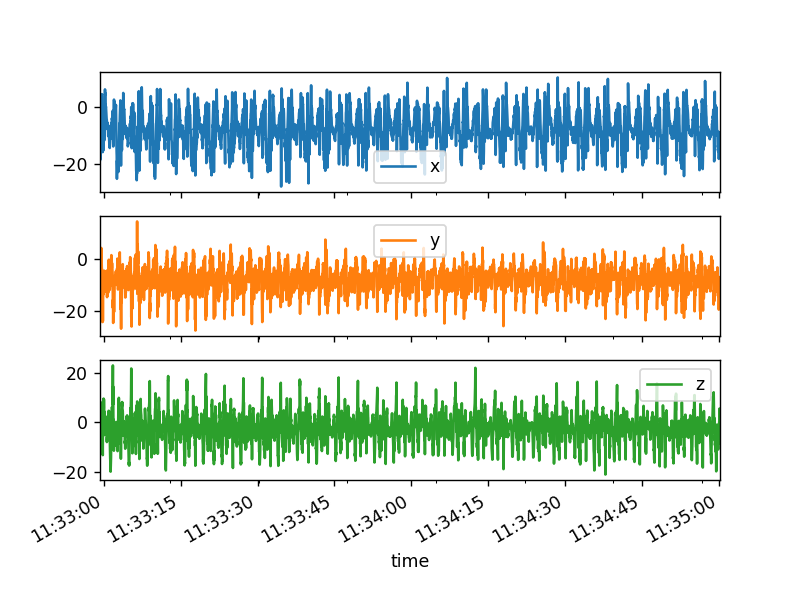

C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\Elise\Anaconda3\lib\site-packages\pandas\plotting\_matpl

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001ABF7A0C9C8>,
      dtype=object)

In [41]:
forward_180.plot(x='time', subplots=True)

In [69]:
#segmentation + feature extraction
forward_180 =  feature_extraction_segmentation(forward_180,1, True)
forward_180

x_mean     y_mean    z_mean      x_min      y_min      z_min     x_max  \
0   -8.494520  -8.438243  0.759353 -18.680767 -24.356543 -13.375878  6.144769   
1   -5.710149 -10.018058 -0.707447 -15.969698 -24.009583 -13.375878  6.144769   
2   -6.584358  -8.698417 -2.185107 -14.502898 -14.754145 -14.835501  4.840680   
3   -8.556366  -5.791735 -2.878520 -14.502898 -15.909878 -20.056639 -1.450050   
4   -5.571687  -7.943757 -3.118676 -13.966906 -24.689144 -20.056639  2.541178   
..        ...        ...       ...        ...        ...        ...       ...   
235 -6.035684  -9.418478 -3.075481 -21.925434 -19.941784 -18.386450  9.111869   
236 -5.525396  -6.689596 -1.911037 -11.401800 -12.708282  -5.395815  9.111869   
237 -9.017490  -5.651663 -4.101942 -11.401800 -12.504891 -16.694723 -5.065606   
238 -7.055744  -7.638856 -2.345472 -19.211973 -17.606388 -16.694723  5.352744   
239 -5.476757  -9.058628 -2.395768 -19.211973 -17.606388 -19.922642  5.352744   

        y_max      z_max     x_std  ...      x_med     y_med     z_med  \
0    4.180261   9.477970  6.570358  ... -10.125229 -8.287541 -0.354138   
1   -4.520042   9.477970  5.725030  ...  -6.630511 -9.428918 -1.098305   
2   -0.346959   4.553542  5.088812  ...  -7.192824 -9.259027 -1.755135   
3    1.426122  17.489141  3.427137  ...  -8.417949 -5.602794 -1.557727   
4    1.426122  22.884956  4.195419  ...  -5.258228 -7.020542 -4.211368   
..        ...        ...       ...  ...        ...       ...       ...   
235 -2.653640   4.424329  7.248350  ...  -6.996614 -9.379865 -2.835495   
236 -2.653640   1.945365  5.588217  ...  -7.759924 -6.716654 -1.867598   
237  0.923630   3.476771  1.477443  ...  -9.354740 -5.533403 -2.807977   
238  0.923630  12.028720  4.680284  ...  -7.558927 -9.311670 -3.846462   
239 -2.335395  12.028720  5.040454  ...  -3.912265 -9.128618 -2.693122   

        activity        sma         smv      tilt        x_psd        y_psd  \
0    forward_180  22.815426  764.516878  2.222162  5953.807138  5869.156032   
1    forward_180  21.000608  701.732629  1.970354  3367.076049  5924.885670   
2    forward_180  19.343394  656.828940  2.103731  3575.092179  4403.493729   
3    forward_180  21.027067  705.089899  2.326253  4406.001045  2670.329058   
4    forward_180  22.429905  756.874499  2.027634  2511.951249  5304.085578   
..           ...        ...         ...       ...          ...          ...   
235  forward_180  21.241415  681.842556  1.905272  4484.832449  5401.224026   
236  forward_180  16.104433  547.993971  2.080955  3180.196535  2652.544343   
237  forward_180  19.408691  656.392866  2.446426  4339.711516  2354.447662   
238  forward_180  22.616085  749.495046  2.157453  3705.901252  4546.334170   
239  forward_180  22.298346  750.485900  2.000602  2855.447886  5079.592519   

           z_psd  
0    1484.936264  
1    1389.932374  
2    1185.563357  
3    4048.929591  
4    5385.181958  
..           ...  
235  1523.343863  
236   392.864334  
237  2273.954832  
238  3742.760739  
239  3858.016936  

[240 rows x 22 columns]

## shuffle - balance data

In [70]:
shape = np.min([jump_fast.shape[0], jump_slow.shape[0], side_swing.shape[0], cross_over.shape[0], forward_180.shape[0]])
print(jump_fast.shape, jump_slow.shape, side_swing.shape, cross_over.shape, forward_180.shape)
jump_fast = shuffle(jump_fast).head(shape).copy()
jump_slow = shuffle(jump_slow).head(shape).copy()
side_swing = shuffle(side_swing).head(shape).copy()
cross_over = shuffle(cross_over).head(shape).copy()
forward_180 = shuffle(forward_180).head(shape).copy()
jump_fast.shape

(208, 22) (180, 22) (237, 22) (118, 22) (240, 22)


(118, 22)

## merge all activities

In [71]:
#merge different activity dataframes
merged = pd.concat([jump_fast, jump_slow, side_swing, cross_over, forward_180], ignore_index=True) 
target = merged['activity']
merged

x_mean    y_mean    z_mean      x_min      y_min      z_min  \
0    -9.195295 -7.691360 -0.643761 -25.567310 -19.525433 -25.679773   
1     5.955266 -7.463120 -5.705381  -5.326423 -23.578875 -12.174682   
2    -9.323035 -6.977379 -2.456278 -25.347170 -20.568703 -25.588846   
3    -7.954728 -7.020635 -3.488923 -31.252657 -21.391834 -19.716858   
4    -6.480468 -8.595817 -0.289156 -26.833113 -22.681566 -20.181067   
..         ...       ...       ...        ...        ...        ...   
585  -3.732527 -8.960246 -0.786318 -15.641882 -23.239094 -12.351750   
586  -6.095578 -8.493922  0.141361 -13.746766 -21.332014 -13.270595   
587 -12.295197 -7.023211 -1.577192 -24.129223 -23.023739 -17.012968   
588  -4.920910 -9.557919 -2.321789 -20.700308 -18.166309 -14.557933   
589  -6.836985 -8.176735 -2.991995 -19.826929 -23.509483 -16.790436   

         x_max      y_max      z_max     x_std  ...      x_med      y_med  \
0     9.669396  19.688145  21.080767  8.755212  ...  -7.885547  -9.266206   
1    45.604805   2.160719   7.104290  9.128919  ...   4.929214  -6.266802   
2    10.435100  11.854043  20.298315  8.842326  ...  -8.872587  -8.656036   
3     3.893122  10.511670  20.238495  7.840908  ...  -5.807381  -7.858029   
4     6.503692  10.566705  16.091732  9.293893  ...  -5.151747  -7.726424   
..         ...        ...        ...       ...  ...        ...        ...   
585   2.644069   0.055035  15.967305  4.123997  ...  -2.610569  -9.272188   
586   1.110270   0.157926  15.914663  3.912297  ...  -5.373083  -8.312665   
587   1.914258   3.852444   8.992228  7.289926  ... -12.279966  -5.944968   
588   4.790431  -2.419144   6.546763  6.578997  ...  -4.438686 -10.231709   
589   1.524228   0.988236  19.444077  4.999891  ...  -5.940182  -8.313862   

        z_med     activity        sma          smv      tilt         x_psd  \
0    0.867398    jump_fast  30.333306  1018.049213  2.041488   8306.120553   
1   -6.726224    jump_fast  21.265672   699.092801  1.202397   5975.583370   
2   -3.689732    jump_fast  28.819524   986.717233  2.056731   8507.310228   
3   -5.692525    jump_fast  27.554385   932.084807  1.985207   6301.153941   
4   -1.277767    jump_fast  25.760707   852.789514  1.917146   6460.641660   
..        ...          ...        ...          ...       ...           ...   
585  0.052642  forward_180  18.315355   623.484472  1.930805   1591.826280   
586  0.798007  forward_180  21.171142   697.389188  2.082116   2712.724792   
587 -0.235693  forward_180  24.621501   861.499605  2.442698  10571.231309   
588 -2.426322  forward_180  19.795399   650.392415  1.844953   3399.143479   
589 -4.537988  forward_180  23.121109   781.311561  2.110074   3705.651102   

           y_psd        z_psd  
0    6195.728708  7289.311915  
1    4892.799348  2516.342979  
2    5883.393885  6092.986792  
3    5072.499094  7408.771639  
4    5726.482134  4448.649449  
..           ...          ...  
585  5638.020214  2306.132992  
586  5253.343261  3092.194858  
587  4550.590600  2149.671001  
588  5412.633209  1217.370335  
589  5681.140603  4652.283148  

[590 rows x 22 columns]

## dimensionality reduction

In [72]:
pca = PCA(n_components=10)
merged = pd.DataFrame(pca.fit_transform(merged.drop('activity', axis=1)))
merged['activity'] = target
merged

0            1            2          3          4          5  \
0    5582.560787  2650.450287 -1881.232695  16.910524   3.626868  -7.856367   
1    2141.119610  -153.447625  1328.897112 -43.907074  22.941178  12.601906   
2    5476.916852  1926.544068  -863.956516  29.740863   3.829663  -3.473351   
3    3446.860740  3491.239134 -1694.123175  11.934009  -3.497248  -4.849043   
4    3160.502266   793.708037  -329.187467  16.550998  -4.609015  -4.546142   
..           ...          ...          ...        ...        ...        ...   
585 -1944.330396  -721.772689  -346.628907   3.076560  -9.364556  -4.097227   
586  -796.507466   111.338338  -221.775888  26.674003  -2.645599  -4.801146   
587  6405.638209  -288.457792  3115.082919  21.748611 -10.260018  -7.983377   
588  -470.566695 -1443.619316   998.718753  22.945785  -9.691506   4.826345   
589   549.352532  1022.632291 -1205.656428  17.341652  -5.735346  -3.359480   

             6         7         8         9     activity  
0     1.156452  5.024586  1.292056 -8.597195    jump_fast  
1    -3.311431  4.261804 -0.815014  5.934393    jump_fast  
2     0.495764  3.195089  3.106547 -2.026286    jump_fast  
3    -6.212395  2.877895 -4.484037  0.786727    jump_fast  
4    -1.793238  4.530895  1.648066 -2.206911    jump_fast  
..         ...       ...       ...       ...          ...  
585  -0.988337  0.682312  3.451229  2.653770  forward_180  
586   1.005733 -0.898951  2.792904  2.287550  forward_180  
587  10.851163 -0.301147 -0.399933  2.030533  forward_180  
588  -2.648177 -2.452432  2.687552 -0.860651  forward_180  
589  -0.386887 -0.775293  1.343954  5.350222  forward_180  

[590 rows x 11 columns]

## train-test split

In [73]:
#TODO: NIET NODIG!!!
#standardize
#scaler = preprocessing.StandardScaler().fit(df)
#df = pd.DataFrame(scaler.transform(df), columns=column_names[2:])

#label activity
le = preprocessing.LabelEncoder()
le.fit(merged['activity'])
merged['activity'] = le.transform(merged['activity'])
labels = le.inverse_transform([0,1,2,3,4])

#train test split
X_train, X_test, y_train, y_test = train_test_split(merged.drop('activity', axis=1), merged['activity'], test_size = 0.33, random_state = 42)

#normalize X
xNormalizer = preprocessing.Normalizer().fit(X_train)
X_train = xNormalizer.transform(X_train)
X_test = xNormalizer.transform(X_test)

# transitions

In [ ]:
def extract_windows(start, length):
    

### jump slow - jump fast

In [218]:
js_jf = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow-jump_fast.csv", sep=';', header=0, skipinitialspace=True)

js_jf = preprocess(js_jf, "js_jf")

js_jf

time          x          y          z activity
205  1970-01-01 11:46:23.479185408  -7.427321 -13.986049  -9.903893    js_jf
206  1970-01-01 11:46:23.495962624 -13.399807 -15.713666 -11.956935    js_jf
207  1970-01-01 11:46:23.516934144 -12.684353 -19.204794 -13.469198    js_jf
208  1970-01-01 11:46:23.533711360  -7.793423 -17.364714 -10.679168    js_jf
209  1970-01-01 11:46:23.558877184  -4.070191 -14.840286  -8.817552    js_jf
...                            ...        ...        ...        ...      ...
2916 1970-01-01 11:47:15.756990464  -2.818745   3.644269 -14.902499    js_jf
2917 1970-01-01 11:47:15.773767680  -4.357330  -2.115255 -15.680167    js_jf
2918 1970-01-01 11:47:15.794739200  -7.716853   1.622334 -17.271395    js_jf
2919 1970-01-01 11:47:15.815710720  -7.724031   2.289931  -9.492328    js_jf
2920 1970-01-01 11:47:15.832487936 -12.253645  -3.498307  -4.268795    js_jf

[2714 rows x 5 columns]

<IPython.core.display.Javascript object>


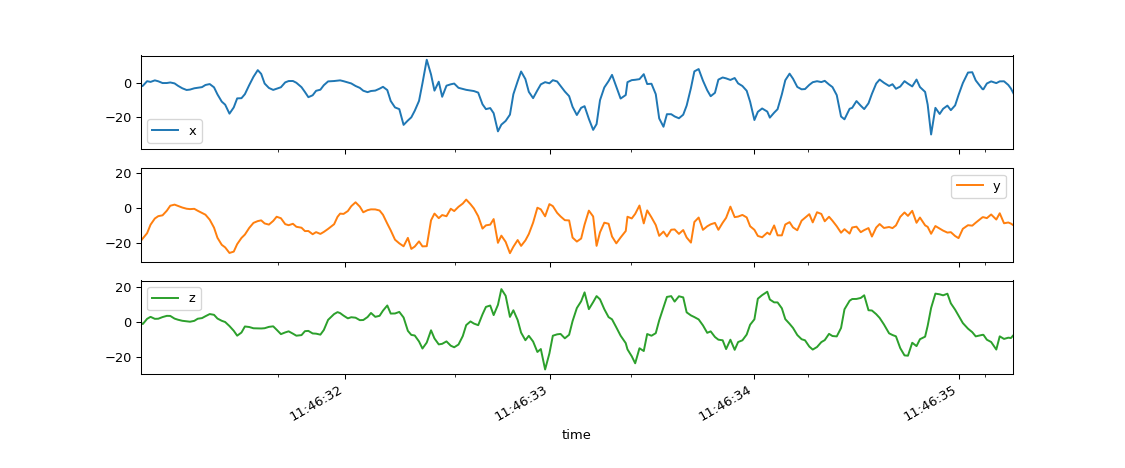

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B0ED49088>,
      dtype=object)

In [219]:
js_jf.plot(x='time', subplots=True)

### jump slow - cross over

In [220]:
js_co = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow-cross_over.csv", sep=';', header=0, skipinitialspace=True)

js_co = preprocess(js_co, "js_co")

js_co

time         x         y          z activity
201  1970-01-01 11:48:41.123659776 -3.699304 -8.360522  -2.562713    js_co
202  1970-01-01 11:48:41.140436992 -4.515256 -9.681360  -3.962514    js_co
203  1970-01-01 11:48:41.161408512 -4.508078 -9.882358  -4.187439    js_co
204  1970-01-01 11:48:41.182380032 -2.354537 -9.822537  -3.330809    js_co
205  1970-01-01 11:48:41.199157248 -1.229911 -9.595219  -3.940979    js_co
...                            ...       ...       ...        ...      ...
1822 1970-01-01 11:49:12.396390400 -2.672783 -4.027121   3.335595    js_co
1823 1970-01-01 11:49:12.421556224 -2.543571 -3.893122   5.056034    js_co
1824 1970-01-01 11:49:12.438333440 -2.210968 -7.800602   5.802595    js_co
1825 1970-01-01 11:49:12.455110656 -2.359323 -8.317451   9.930214    js_co
1826 1970-01-01 11:49:12.476082176 -1.241875 -9.999606  16.790436    js_co

[1624 rows x 5 columns]

<IPython.core.display.Javascript object>


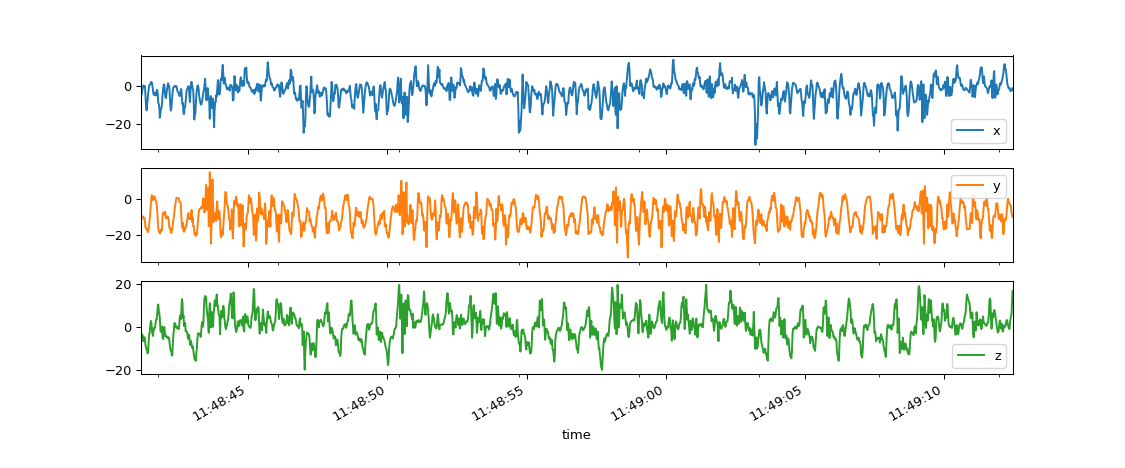

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B72276B88>,
      dtype=object)

In [221]:
js_co.plot(x='time', subplots=True)

### jump slow - side swing

In [222]:
js_ss = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow-side_swing.csv", sep=';', header=0, skipinitialspace=True)

js_ss = preprocess(js_ss, "js_ss")

js_ss

time         x          y         z activity
200  1970-01-01 11:50:07.559876608 -0.859023  -9.714860 -6.697511    js_ss
201  1970-01-01 11:50:07.580848128  5.051249 -10.504492 -5.905486    js_ss
202  1970-01-01 11:50:07.597625344  6.601798 -10.006784 -4.599005    js_ss
203  1970-01-01 11:50:07.618596864 -1.210768  -7.898707 -3.828516    js_ss
204  1970-01-01 11:50:07.635374080  0.260818 -12.325429 -4.424329    js_ss
...                            ...       ...        ...       ...      ...
3699 1970-01-01 11:51:15.075588096 -4.539185  -6.525228 -6.879365    js_ss
3700 1970-01-01 11:51:15.100753920 -2.249253  -7.075577 -5.998806    js_ss
3701 1970-01-01 11:51:15.125919744 -1.268196  -7.640283 -5.874380    js_ss
3702 1970-01-01 11:51:15.134308352 -0.047856  -7.379465 -7.015756    js_ss
3703 1970-01-01 11:51:15.155279872  0.179462  -9.518648 -6.245267    js_ss

[3503 rows x 5 columns]

<IPython.core.display.Javascript object>


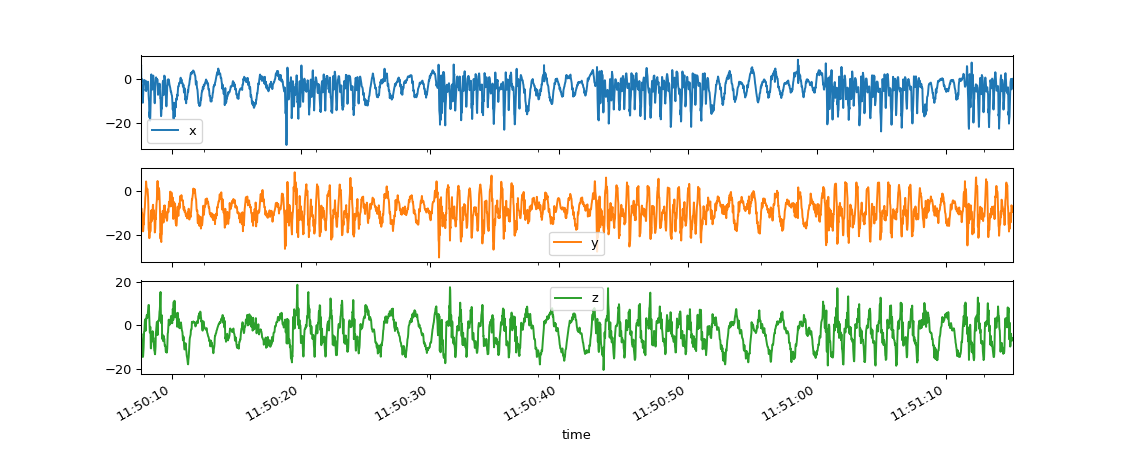

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B107F92C8>,
      dtype=object)

In [223]:
js_ss.plot(x='time', subplots=True)

### jump slow - forward 180

In [224]:
js_f180 = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow-forward_180.csv", sep=';', header=0, skipinitialspace=True)

js_f180 = preprocess(js_f180, "js_f180")

js_f180

time          x          y          z activity
203  1970-01-01 11:51:58.625046528 -11.578869 -13.540983 -17.570498  js_f180
204  1970-01-01 11:51:58.646018048  -9.186047 -12.983456 -17.218752  js_f180
205  1970-01-01 11:51:58.662795264  -5.922236 -12.763316 -14.723038  js_f180
206  1970-01-01 11:51:58.683766784  -2.940779 -12.827922  -9.133404  js_f180
207  1970-01-01 11:51:58.704738304   0.011964 -12.004791  -5.331209  js_f180
...                            ...        ...        ...        ...      ...
3395 1970-01-01 11:53:00.218400768   1.820938 -10.358529  -4.271188  js_f180
3396 1970-01-01 11:53:00.239372288   3.297310 -10.281959  -3.194418  js_f180
3397 1970-01-01 11:53:00.256149504   3.646662  -6.501299  -1.940579  js_f180
3398 1970-01-01 11:53:00.277121024   3.864408  -1.500300  -1.028914  js_f180
3399 1970-01-01 11:53:00.293898240   2.478964   1.447658  -0.815953  js_f180

[3196 rows x 5 columns]

<IPython.core.display.Javascript object>


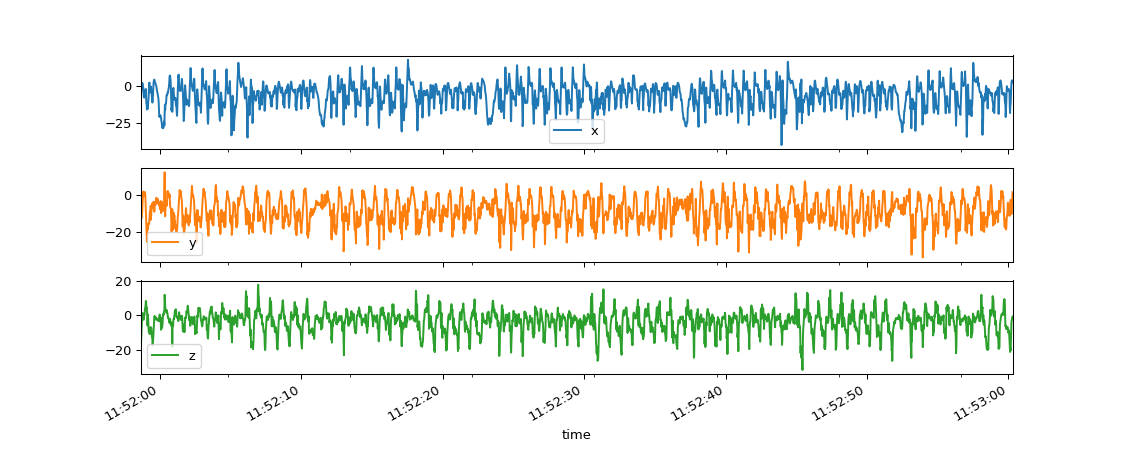

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B10DAB508>,
      dtype=object)

In [225]:
js_f180.plot(x='time', subplots=True)

# machine learning algorithms

## SVC

<IPython.core.display.Javascript object>


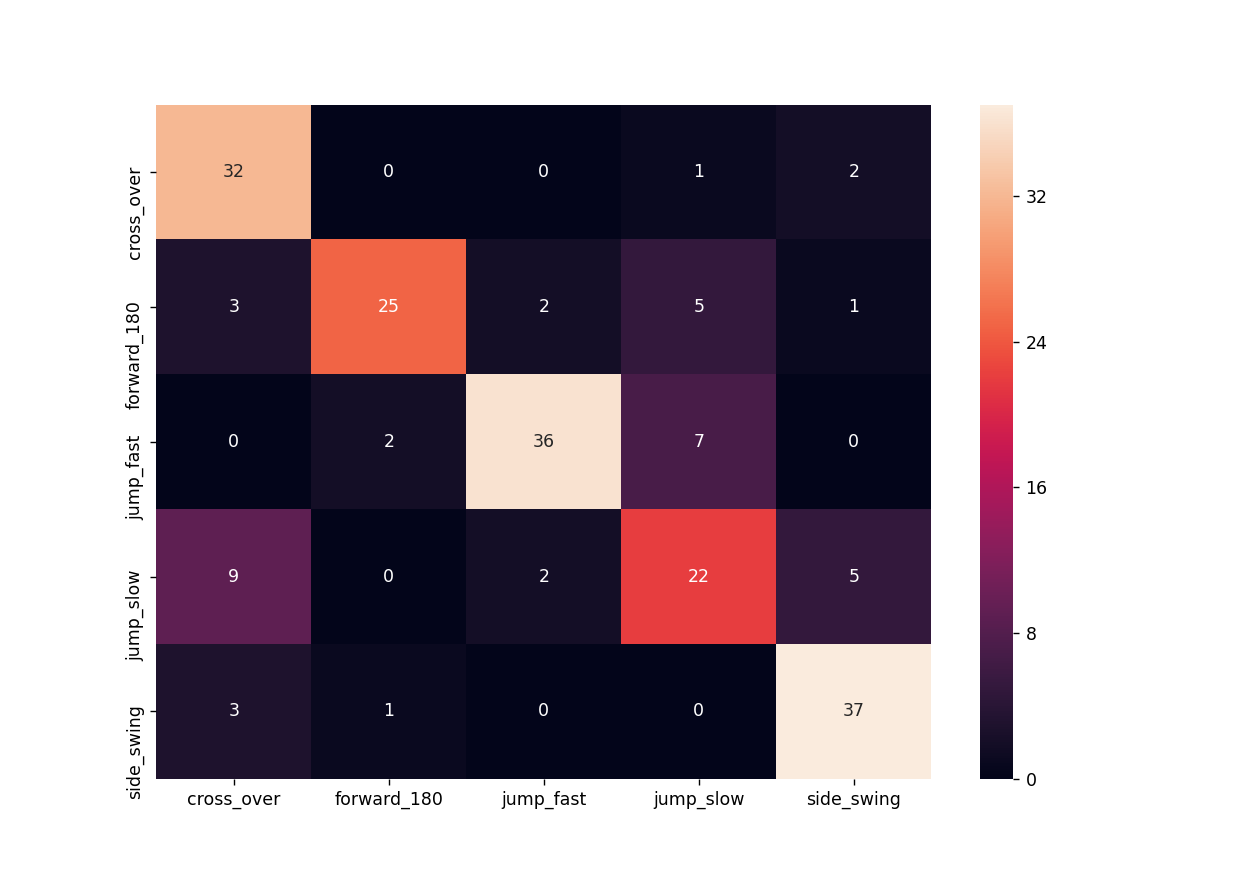

In [74]:
#hyperparameter tuning
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['linear','rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True) #verbose=2
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

<IPython.core.display.Javascript object>


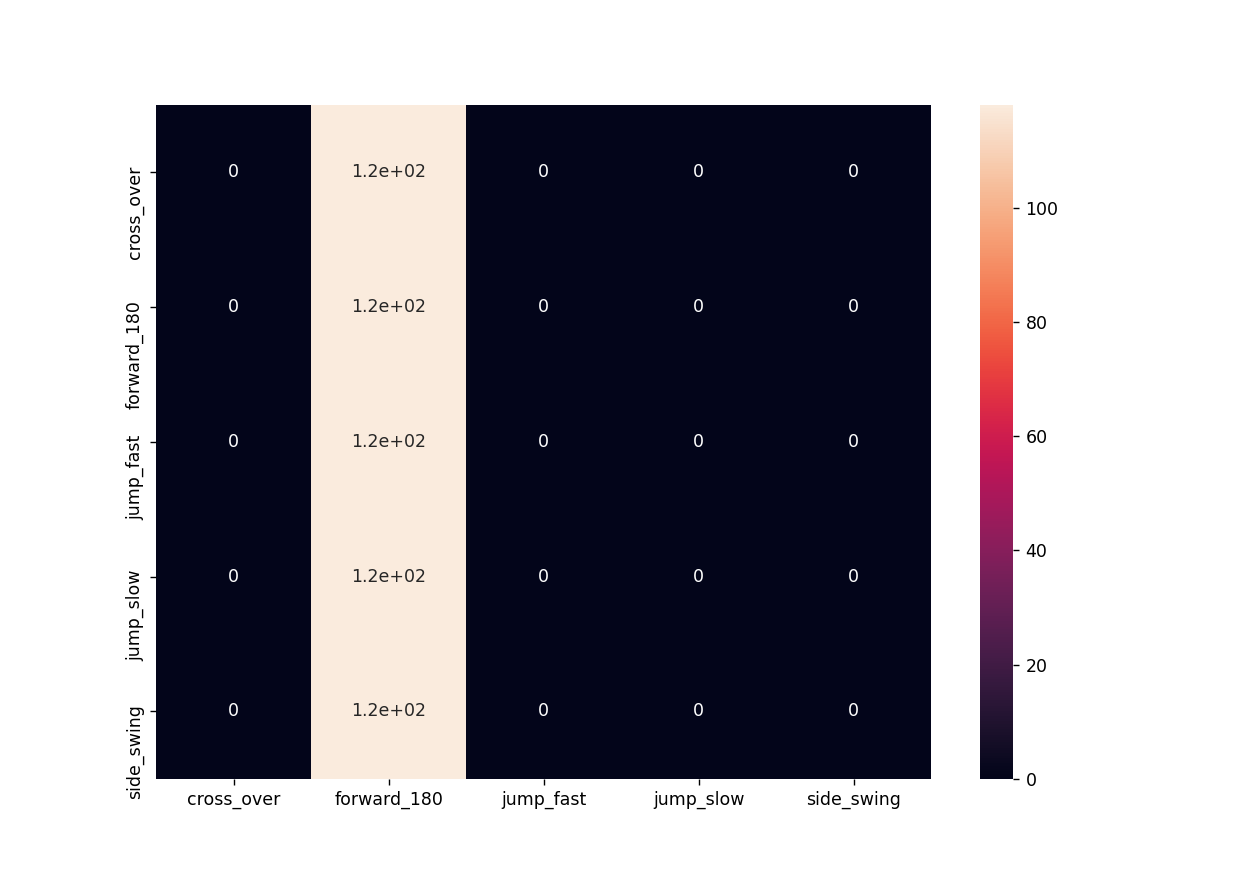

In [75]:
y_pred = clf.predict(merged.drop('activity', axis=1).to_numpy())
cm = confusion_matrix( merged['activity'].to_numpy(), y_pred)

heatmap(cm, labels)

## linear SVC

<IPython.core.display.Javascript object>


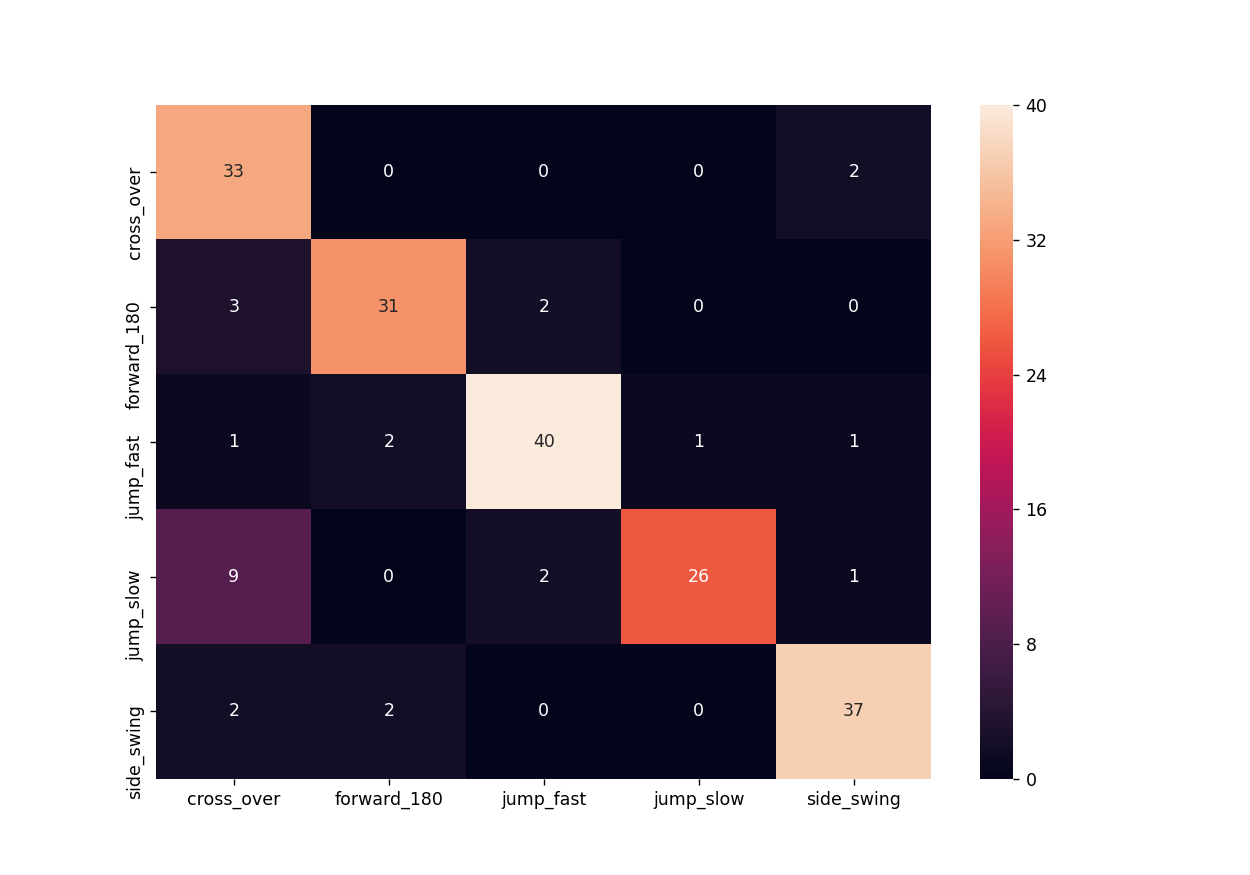

In [76]:
#hyperparameter tuning
param_grid = {'C': [0.1,1, 10, 100]}
grid = GridSearchCV(LinearSVC(),param_grid,refit=True)
grid.fit(X_train,y_train)

clf =  grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm,labels)

## random forest

In [ ]:
#hyperparameter tuning
param_grid = {'n_estimators': [100, 1000],
              'max_depth': [10, 20],'min_samples_split': np.arange(0.10, 1, 0.4) ,
              'max_leaf_nodes': [10, 100, 1000, None]}
grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)

## extra trees classifier

In [ ]:
#hyperparameter tuning
param_grid = {'n_estimators': [10, 100, 1000],
              'max_depth': [1,10,20,30],'min_samples_split': np.arange(0.10, 1, 0.2) ,
                'max_leaf_nodes': [10, 100, 1000, None]}
grid = GridSearchCV(ExtraTreesClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm)

## AdaBoost

In [ ]:
#hyperparameter tuning
param_grid = {'learning_rate': np.arange(0.10, 1, 0.2), 'n_estimators': [10, 50, 100, 1000],
              'base_estimator': [RandomForestClassifier(), ExtraTreesClassifier()], 
              'algorithm' : ['SAMME', 'SAMME.R']}
grid = GridSearchCV(AdaBoostClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm)

## naive bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm)

## kneighbors 

In [ ]:
#hyperparameter tuning
param_grid = {'n_neighbors': [1,2,4,8,10], 'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'leaf_size': range(1,60,10), 
              'metric' : ['minkowski']}
grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm)

## SGD classifier

In [ ]:
#hyperparameter tuning
param_grid = {'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'], 
              'max_iter': [10, 100, 1000], #np.ceil(10**6 / n) 
             'shuffle' : [True], 'eta0' : [1]}
grid = GridSearchCV(SGDClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm)

## MLP classifier

Fitting 3 folds for each of 864 candidates, totalling 2592 fits
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=0.0001, hidden_l

[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=0.0001, hidden_layer_siz

[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=  

[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=0.001, hidden_la

[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV

[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_

[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.1s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=  

[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=co

[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learnin

[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.2s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 50, 50),

[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.5s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.5s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(50, 100, 50), lear

[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=identity, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_r

[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes

[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[

[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=100.0, hidden_l

[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=identity, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, 

[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=identity, alpha=1000.0, hidden_layer_s

[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=identity, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=identity, alpha=1000.0, hidden_layer_sizes=(100

[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.5s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=logistic, alpha=0.0001, hidden_layer

[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.0s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.1s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs, total=   0.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs, total=   0.4s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.0001, hidden

[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 50, 

[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.1s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.2s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.3s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.4s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=logistic, alpha=0.001, hidden_layer_

[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.1s
[CV] activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=logistic, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.

[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.5s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   2.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.7s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.1s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=logistic, alpha=0.01, hidden_laye

[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.1s
[CV] activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=logistic, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activ

[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=adap

[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.1s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.1s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV

[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 50, 50), learning_rate=co

[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learnin

[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.4s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50,

[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(50, 100, 

[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 50, 50), l

[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=100.0, hidden_

[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=logistic, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=  

[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=logistic, alpha=1000.0, hidden_

[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=logistic, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=constant, sol

[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=ada

[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, 

[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sg

[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, sol

[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, so

[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs, total=   0.2s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solv

[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.3s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.3s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.3s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solve

[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.4s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.4s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=

[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(50

[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.5s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, sol

[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=1.0, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=1.0, hidden_layer_sizes

[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.5s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.4s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.4s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invsca

[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam 
[CV]  activation=tanh, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=tanh, alpha=10.0, hidden_layer_s

[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, s

[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=tanh, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=tanh

[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=ada

[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.5s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd 
[CV]  activation=tanh, alpha=1000.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.0

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, 

[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adap

[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50, 50), learning_rate=con

[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs, total=   0.3s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(50, 100, 50), learning_rate=adapt

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=lbfgs, total=   0.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=invscali

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs, total=   0.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sg

[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam, total=   0.2s
[CV] activation=relu, alpha=0.01, hidden_layer_s

[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.5s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.4s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=adam, total=   0.3s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, so

[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=lbfgs, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=0.1, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=0.1, hidden_layer_si

[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=lbfgs, total=   0.6s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, solver=sgd 
[CV]  activation=relu, alpha=1.0, hidden_layer_sizes=(50, 100, 50), learning_rate=invscaling, 

[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, total=   0.3s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=   0.3s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, total=

[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=adam, total=   0.2s
[CV] activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs 
[CV]  activation=relu, alpha=10.0, hidden_layer_sizes=(100,), learning_rate=constant, solver=lbfgs, total=   0.0s
[CV] activation=relu, alpha=

[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, total=   0.3s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=lbfgs 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, so

[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, total=   0.5s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=lbfgs, total=   0.0s
[CV] activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd 
[CV]  activation=relu, alpha=100.0, hidden_layer_sizes=(100,), learning_rate=invscaling, solver=sgd, total=   0.2s
[CV] ac

[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.0s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.0s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, total=   0.0s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, sol

[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=lbfgs, total=   0.1s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.2s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.1s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, total=   0.1s
[CV] activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=1000.0, hidden_layer_sizes=(50, 100, 50), learning_rate=adap

[Parallel(n_jobs=1)]: Done 2592 out of 2592 | elapsed:  9.2min finished


<IPython.core.display.Javascript object>


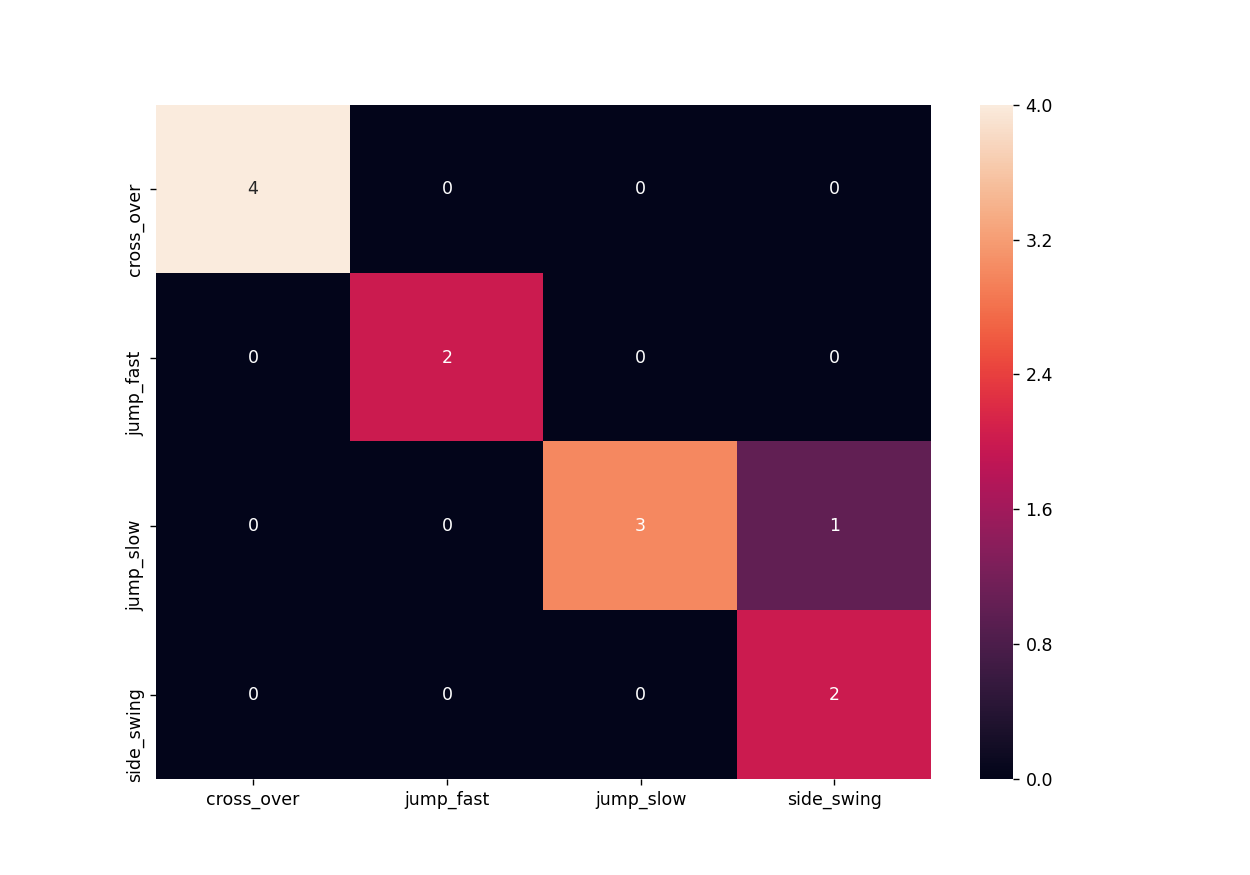

In [35]:
#hyperparameter tuning
param_grid = {'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], 
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)], 'activation': ['identity', 'logistic','tanh', 'relu'],
    'learning_rate': ['invscaling', 'constant','adaptive']}
grid = GridSearchCV(MLPClassifier(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

clf = grid.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

heatmap(cm, labels)